In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
%matplotlib inline

from matplotlib import gridspec
import statsmodels.api as sm

import seaborn as sns
from matplotlib import colors

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
todaystring = datetime.date.today().strftime("%y%m%d")

import ModelFitFunctions
from ModelFitFunctions import *

import TrendAnalysisFunctions
from TrendAnalysisFunctions import *

# Comments on included prevalence data
1. The positive tests data has been aggregated over all zip codes that overlap each respective WRP catchment area, and then a centered rolling 7-day average smoothing function has been applied.  
    1. For the large WRPs (Stickney, Calumet, and O'Brien), this data was obtained directly from the Illinois Department of Public Health, with date referring to the date of an individual's test, and is the data that was used in generating results and figures in the manuscript and suplement.  
    2. For the smaller WRPs (Egan, Kirie, Hanover Park, and Lemont), this data was also obtained from the Illinois Department of Public Health via their public API, with date referring to the date the tests were reported to the health department.  This data was then shifted back 2 days to account for reporting delays so as to more closely match the original sensitive data.  It is also scaled such that its maximum for each WRP between November 2020 to November 2021 is equal to the maximum of the sensitive data during the same time frame.  Due to small population sizes, we are unable to post the data used to generate figures and results in the manuscript and supplement, but this data can act as a proxy.  
2. To obtain the test positivity rate data, total positive tests and total tests have each been aggregated over all zip codes that overlap each respective WRP catchment area, and then a centered rolling 7-day average smoothing function has been applied.  Finally the resulting positive tests was divided by the total tests, to obtain test positivity rate.  For each WRP, this data was obtained from the Illinois Department of Pulic Health via their public API, with date referring to the date the tests were reported to the health department.  This data was used in generating results and figures in the manuscript and supplement.  
3. The hospital admissions data was obtained from the Illinois Deparment of Public Health via their public API as regional data.  It is also scaled such that its maximum for each WRP between November 2020 to November 2021 is equal to the maximum of the sensitive data during the same time frame.  Due to low hospitalization rates, we are unable to post the data used to generate figures and results in the manuscript and supplement, but this data can act as a proxy.  Some portions of the figures do change if the pipeline is run on this dataset.
    1. For the large WRPs (Stickney, Calumet, and O'Brien), the 7-day averaged totals for Chicago (COVID region 11) and the 7-day averaged totals for suburban Cook County (COVID region 10) are combined to obtain a total Cook County metric.  
    2. For the smaller plants we only include the 7-day averaged totals for suburban Cook County (COVID region 10).    
4. The beds in use data was also obtained from the Illinois Department of Public Health via their public API as regional data.  This data was used in generating results and figures in the manuscript and supplement.  
    1. For the large WRPs (Stickney, Calumet, and O'Brien), the 7-day averaged totals for Chicago (COVID region 11) and the 7-day averaged totals for suburban Cook County (COVID region 10) are combined to obtain a total Cook County metric.  
    2. For the smaller plants we only include the 7-day averaged totals for suburban Cook County (COVID region 10).  
    
    
We thank the Illinois Department of Public Health for their partnership with the University of Illinois and Northwestern in the code and data provided in this repository.  

The conclusions, opinions, or recommendations are those of the authors and not of IDPH.

In [2]:
filepath = 'data'

wbefile = 'data/wastewater.csv'

prevfile = 'data/clinical.csv'
# namestring = '_qpcr_fits_230825'
# earlynamestring = '_qpcr_fits_trainearly_230825'

namestring = '_qpcr_fits_sensitive_230825'
earlynamestring = '_qpcr_fits_trainearly_sensitive_230825'

paramfile = 'data/fitparams'+namestring+'.csv'
paramearlyfile = 'data/fitparams'+earlynamestring+'.csv'
aicfile = 'data/fitaic'+namestring+'.csv'
aicfullfile = 'data/fitaic'+earlynamestring+'.csv'

firstdate = '2020-10-01'
lastdate = '2022-01-01'
catches_shortlist = ['Stickney','Calumet','OBrien']
catches_correlation = ['Stickney','Calumet','OBrien','Egan','Hanover','Kirie','Lemont']
lag = 2
wwtp = 'comb'


# last one in this should be beds or latest...
useprevs_trendflags = ['positive tests','hospital admissions','Cook County beds in use']
plabs = ['C','A'] # labels for flags for all but last.

useprev_single = 'hospital admissions'
usewws = ['orig-raw_data','pmmov_bcov_flow_norm']
wwlabs = ['Raw SARS-CoV-2','Corrected Wastewater']

ww_lod = 67 # limit of detection for wastewater data


prevenddate = {'positive tests':'2022-11-01', 
               'test positivity rate':'2022-04-06', 
               'hospital admissions':'2022-07-15', 
               'Cook County beds in use':'2022-09-20'}

num_weeks_ww = 4
num_weeks_prev = 4
prev_CI = 66
ww_CI = 66
prev_daythresh = 15
ww_daythresh = 15

fs1 = 22
fs2 = 24
fs3 = 18
fs4 = 18
# early on, should check that the above listed items do fall in the dataframes that are read in

allprev = ['positive tests', 'test positivity rate', 'hospital admissions', 'Cook County beds in use']
trymodels = ['raw_data','only_flow_norm','pmmov_norm','only_bcov_norm','bcov_flow_norm','pmmov_bcov_norm','pmmov_bcov_flow_norm']
whatiscomb = catches_shortlist
myend = '2022-01-01'
altend = '2022-01-01'
myshortend = '2022-08-01'
lags = np.arange(-10,11)

## Format wbe and other dfs

In [3]:
wbe = pd.read_csv(wbefile, parse_dates=['date'])
wbe.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
prevdf = pd.read_csv(prevfile, parse_dates=['date'])
prevdf.rename(columns={'wrp':'catchment'},inplace=True)

paramdf = pd.read_csv(paramfile)
aicdf = pd.read_csv(aicfile)

wbe = CalculateModelFitsFromParams(wbe,paramdf,ww_lod,wwtp,lag,useprev_single)
wbe.info()

wbe_early = pd.read_csv(wbefile, parse_dates=['date'])
wbe_early.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)

paramearlydf = pd.read_csv(paramearlyfile)
aicfulldf = pd.read_csv(aicfullfile)

wbe_early = CalculateModelFitsFromParams(wbe_early,paramearlydf,ww_lod,wwtp,lag,useprev_single)
wbe_early.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       670 non-null    datetime64[ns]
 1   catchment                  670 non-null    object        
 2   raw_data                   670 non-null    float64       
 3   bcov_recovery              670 non-null    float64       
 4   pmmov                      670 non-null    float64       
 5   flow                       670 non-null    float64       
 6   orig-only_bcov_norm        670 non-null    float64       
 7   orig-bcov_flow_norm        670 non-null    float64       
 8   orig-pmmov_norm            670 non-null    float64       
 9   orig-pmmov_bcov_norm       670 non-null    float64       
 10  orig-pmmov_bcov_flow_norm  670 non-null    float64       
 11  orig-only_flow_norm        670 non-null    float64       
 12  orig-raw

In [4]:
prevlagdict,prevbounds = get_prevlags(prevdf,catches_shortlist,allprev,prevenddate,'2020-08-01','2022-04-01',corthresh=0.00129,wlags=[-2,5],plotcors=False)

Correlating: positive tests test positivity rate
	max lag = 3 	other lags =  [3 4]
	 [0, 10]
 Possible offsets: [[3], [4]]
 wlags = [[-2, 5], [0, 10]]

Correlating: positive tests hospital admissions
	max lag = 2 	other lags =  [2 3]
	 [-1, 9]
Correlating: test positivity rate hospital admissions
	max lag = 1 	other lags =  [0 1]
	 [-1, 9]
 Possible offsets: [[3, 3]]
 wlags = [[-2, 5], [0, 10], [-1, 9]]

Correlating: positive tests Cook County beds in use
	max lag = 9 	other lags =  [ 8  9 10]
	 [5, 16]
Correlating: test positivity rate Cook County beds in use
	max lag = 8 	other lags =  [7 8]
	 [5, 16]
Correlating: hospital admissions Cook County beds in use
	max lag = 7 	other lags =  [6 7]
	 [5, 16]
 Possible offsets: [[3, 3, 10]]
 wlags = [[-2, 5], [0, 10], [-1, 9], [5, 16]]

{'positive tests': 0, 'test positivity rate': 3, 'hospital admissions': 3, 'Cook County beds in use': 10}


prevind  lower  upper
0           positive tests     -2      5
1     test positivity rate     -3      7
2      hospital admissions     -4      6
3  Cook County beds in use     -5      6

In [5]:
aic2,param2,models = reformat_aic_params(aicdf,paramdf,trymodels)

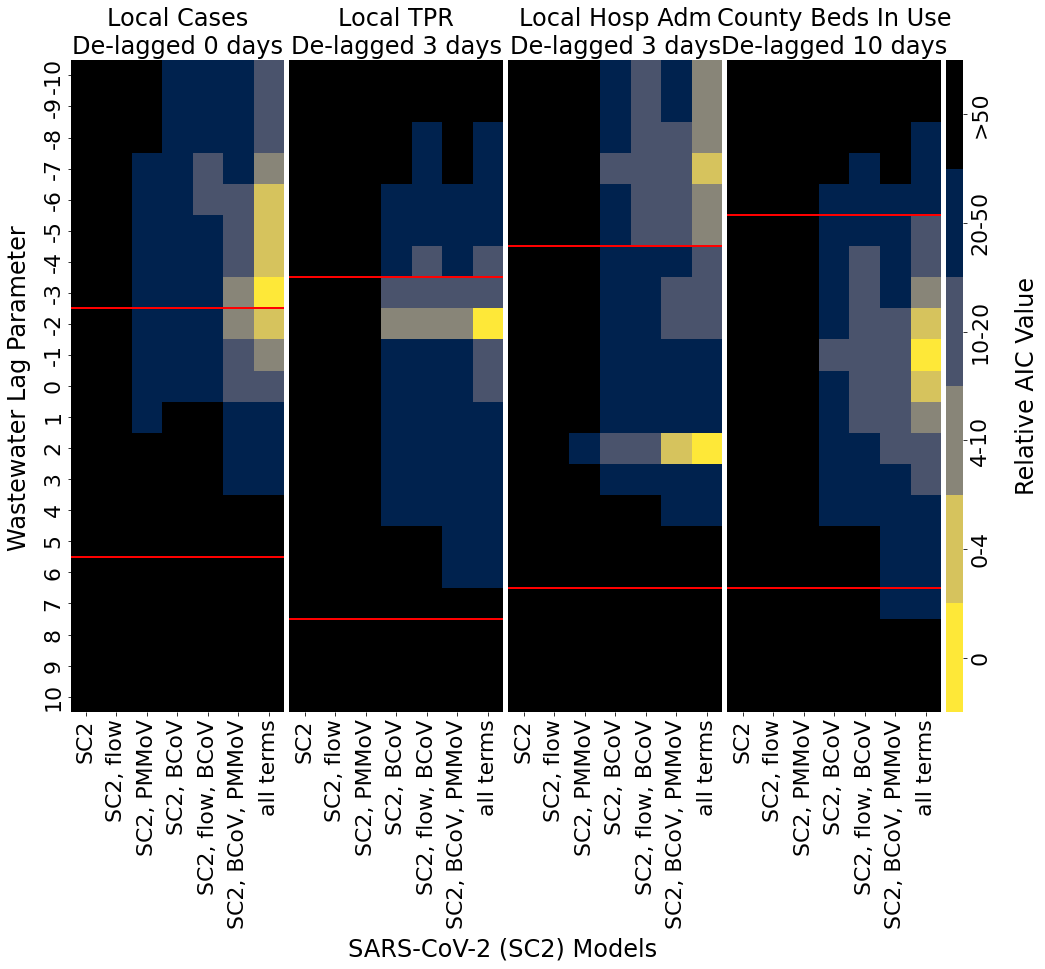

In [6]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels & axis titles
aicprevs = ['positive tests','test positivity rate','hospital admissions','Cook County beds in use']
aic2.prevind=pd.Categorical(aic2.prevind,categories=aic2.prevind.unique(),ordered=True)
aic2.model=pd.Categorical(aic2.model,categories=aic2.model.unique(),ordered=True)
pivotedaic = aic2[(aic2.model.isin(models)) & (aic2.wwtp==wwtp)].pivot_table(index = ['lag'],
                         columns = ['prevind','model'],sort=False)
newmapaic = aic_colormap()
offset = {}
for prev in aic2.prevind.unique():
    offset[prev] = pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min()
    pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)] = pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].sub(pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min(),axis=1).values
rel = ' - rel AIC across models and lags for each prev'

modtermdict = {'no correction':'SC2',
               'only flow':'SC2, flow',
               'pmmov norm':'SC2, PMMoV', 
               'only bcov norm':'SC2, BCoV',
               'bcov flow norm':'SC2, flow, BCoV',
               'pmmov bcov norm':'SC2, BCoV, PMMoV',
               'pm bc fl':'all terms'}
prevnamedict = {'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'hospital admissions':'Local Hosp Adm',
 'Cook County beds in use':'County Beds In Use'}
nplots = len(aicprevs)
fig = plt.figure(figsize=(nplots*4,12))
gs = fig.add_gridspec(1, nplots+1, hspace=0.03, wspace=0.03,width_ratios=[1]*nplots+[0.08])
axs = gs.subplots()
for n,prevind in enumerate(aicprevs):
    melted = pd.melt(pivotedaic['aic',prevind],var_name='model',value_name='aic',ignore_index=False)
    melted.aic = melted.aic.apply(lambda x:discrete_color_aic(x))
    melted.model=pd.Categorical(melted.model,categories=models,ordered=True)
    # Updates: allow for variably chosen models to show here...
    newpivotedaic = melted[(melted.model.str.contains('new')) & ~(melted.model.isin([' new only flow aic',' new no correction aic',' new pmmov norm aic']))].pivot_table(index=['lag'],columns=['model'],sort=False)
    if n<nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,cbar=False,vmin=-0.5,vmax=5.5,ax= axs[n])
    if n==nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,vmin=-0.5,vmax=5.5,ax= axs[n],cbar_ax=axs[n+1])
    mymods = [modtermdict[m[4:-4]] for m in newpivotedaic.aic.columns.tolist()]
    uselags = newpivotedaic.aic.index.tolist()
    axs[n].set_xticks(np.linspace(0.5,0.5*(len(mymods)*2-1),len(mymods)))
    axs[n].set_xticklabels(mymods, fontsize = fs1)
    axs[n].set_xlabel('Model',fontsize=fs2)
    axs[n].set_yticks(np.linspace(0.5,0.5*(len(uselags)*2-1),len(uselags)))
    axs[n].set_yticklabels(uselags, fontsize = fs1)
    axs[n].set_xlabel('')
    axs[n].set_ylabel('')
    if n>0:
        axs[n].set_yticks([])
    # Updates: if lags is not every integer from -10 to 10, this does not show the right lines...
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind].upper.iloc[0]+11,color='r',linewidth=2) # upper
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind].lower.iloc[0]+10,color='r',linewidth=2) # lower
    if n==nplots-1:
        colorbar = axs[n+1]#.collections[0].colorbar
        colorbar.set_yticks([0,1,2,3,4,5])
        colorbar.set_yticklabels(['0','0-4', '4-10', '10-20', '20-50', '>50'],rotation=90,\
                                 verticalalignment='center',horizontalalignment='left',fontsize=fs1)
        plt.annotate('Relative AIC Value',xy=(1,1),xycoords='figure fraction',
                               xytext=(4, 2.5), textcoords='data',
                               horizontalalignment='left',verticalalignment='center',rotation=90,fontsize=fs2)
    axs[n].set_title(prevnamedict[prevind]+'\nDe-lagged '+str(int(prevlagdict[prevind]))+' days',fontsize=fs2)

fig.text(0.07, 0.5,'Wastewater Lag Parameter', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.5, -.15, 'SARS-CoV-2 (SC2) Models', va='center', rotation='horizontal',ha='center',fontsize=fs2)
plt.show()

In [7]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewws,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewws,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

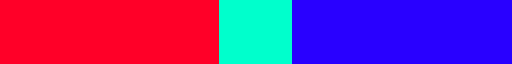

In [8]:
base = plt.cm.get_cmap('gist_rainbow')
color_list = base(np.array([0,0,0,.55,.8,.8,.8]))
newmap = ListedColormap(color_list,'newmap')

newmap

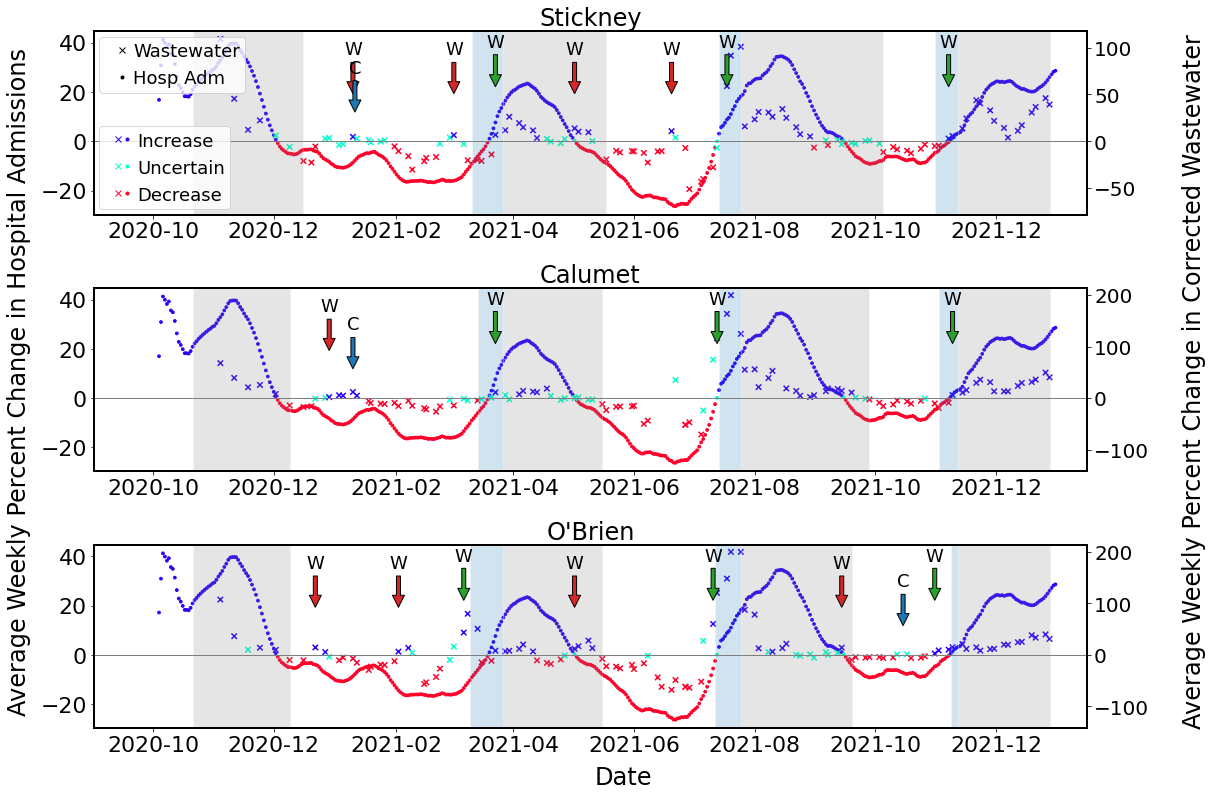

In [9]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
mycolors0 = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']
wws = usewws    
num_weeks = num_weeks_ww
add_surge_arrows=False
n = 0
datatype = 'pmmov_bcov_flow_norm'
datalabel = 'Corrected Wastewater'
fig = plt.figure(figsize=(16,11))
gs = fig.add_gridspec(len(catches_shortlist), 1, wspace=None, hspace=None)
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
            if c==0: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('hospital admissions','Hosp Adm'))
                l1 = ax.legend(bbox_to_anchor=(0,1),loc='upper left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0,0),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch,'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors0[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors0[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors0[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(30,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
fig.text(0.5, 0, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(-.01, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('hospital admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(1.01, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()


In [10]:
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2020-12-29'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-09-20'),'surge'] = '2021-11-12, pre:2021-09-14'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2021-01-10'
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])


source catchment  wastewater       cases  admissions    bedsused  \
0        Calumet  2020-12-29         NaN         NaN         NaN   
1        Calumet         NaN  2021-01-10         NaN         NaN   
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27   
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25   
4        Calumet  2021-11-09  2021-11-02  2021-11-08  2021-11-12   
5         OBrien  2020-12-22         NaN         NaN         NaN   
6         OBrien  2021-02-02         NaN         NaN         NaN   
7         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27   
8         OBrien  2021-05-02         NaN         NaN         NaN   
9         OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25   
10        OBrien  2021-09-14         NaN         NaN         NaN   
11        OBrien         NaN  2021-10-15         NaN         NaN   
12        OBrien  2021-10-31         NaN  2021-11-08  2021-11-12   
13      Stickney  2021-01-10         NaN         NaN         NaN   
14      Stickney         NaN  2021-01-11         NaN         NaN   
15      Stickney  2021-03-02         NaN         NaN         NaN   
16      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27   
17      Stickney  2021-05-02         NaN         NaN         NaN   
18      Stickney  2021-06-20         NaN         NaN         NaN   
19      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25   
20      Stickney  2021-11-07  2021-10-31  2021-11-08  2021-11-12   

source                       surge     w-a     c-a      b-a      w-c     w-b  
0       2021-03-27, pre:2020-12-29     NaT     NaT      NaT      NaT     NaT  
1       2021-03-27, pre:2021-01-10     NaT     NaT      NaT      NaT     NaT  
2                 2021-03-27-surge -3 days  6 days  -7 days  -9 days  4 days  
3                 2021-07-25-surge  1 days  0 days -11 days   1 days 12 days  
4                 2021-11-12-surge -1 days  6 days  -4 days  -7 days  3 days  
5       2021-03-27, pre:2020-12-22     NaT     NaT      NaT      NaT     NaT  
6       2021-03-27, pre:2021-02-02     NaT     NaT      NaT      NaT     NaT  
7                 2021-03-27-surge 13 days 10 days  -7 days   3 days 20 days  
8       2021-07-25, pre:2021-05-02     NaT     NaT      NaT      NaT     NaT  
9                 2021-07-25-surge  3 days  2 days -11 days   1 days 14 days  
10      2021-11-12, pre:2021-09-14     NaT     NaT      NaT      NaT     NaT  
11      2021-11-12, pre:2021-10-15     NaT     NaT      NaT      NaT     NaT  
12                2021-11-12-surge  8 days     NaT  -4 days      NaT 12 days  
13      2021-03-27, pre:2021-01-10     NaT     NaT      NaT      NaT     NaT  
14      2021-03-27, pre:2021-01-11     NaT     NaT      NaT      NaT     NaT  
15      2021-03-27, pre:2021-03-02     NaT     NaT      NaT      NaT     NaT  
16                2021-03-27-surge -3 days  9 days  -7 days -12 days  4 days  
17      2021-07-25, pre:2021-05-02     NaT     NaT      NaT      NaT     NaT  
18      2021-07-25, pre:2021-06-20     NaT     NaT      NaT      NaT     NaT  
19                2021-07-25-surge -4 days  0 days -11 days  -4 days  7 days  
20                2021-11-12-surge  1 days  8 days  -4 days  -7 days  5 days

Wastewater leads admissions in 5 surges by up to 13 days, and lags admissions in 4 surges by up to 4 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 3 days, and lags cases in 5 surges by up to 12 days.
Wastewater leads beds-in-use in all surges by 3 to 20 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet  2020-12-29         NaN         NaN         NaN
1        Calumet         NaN  2021-01-10         NaN         NaN
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
4        Calumet  2021-11-09  2021-11-02  2021-11-08  2021-11-12
5         OBrien  2020-12-22         NaN         NaN         NaN
6         OBrien  2021-02-02         NaN         NaN         NaN
7         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27
8         OBrien  2021-05-02         NaN         NaN         NaN
9         OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25
10        OBrien  2021-09-14         NaN         NaN         NaN
11        OBrien         NaN  2021-10-15         NaN         NaN
12        OBrien  2021-10-31         NaN  2021-11-08  2021-11-12
13      Stickney  2021-01-10         NaN         NaN         NaN
14      Stickney         NaN  2021-01-11         NaN         NaN
15      Stickney  2021-03-02         NaN         NaN         NaN
16      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27
17      Stickney  2021-05-02         NaN         NaN         NaN
18      Stickney  2021-06-20         NaN         NaN         NaN
19      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
20      Stickney  2021-11-07  2021-10-31  2021-11-08  2021-11-12

In [11]:
surgebest = surgedf.copy()

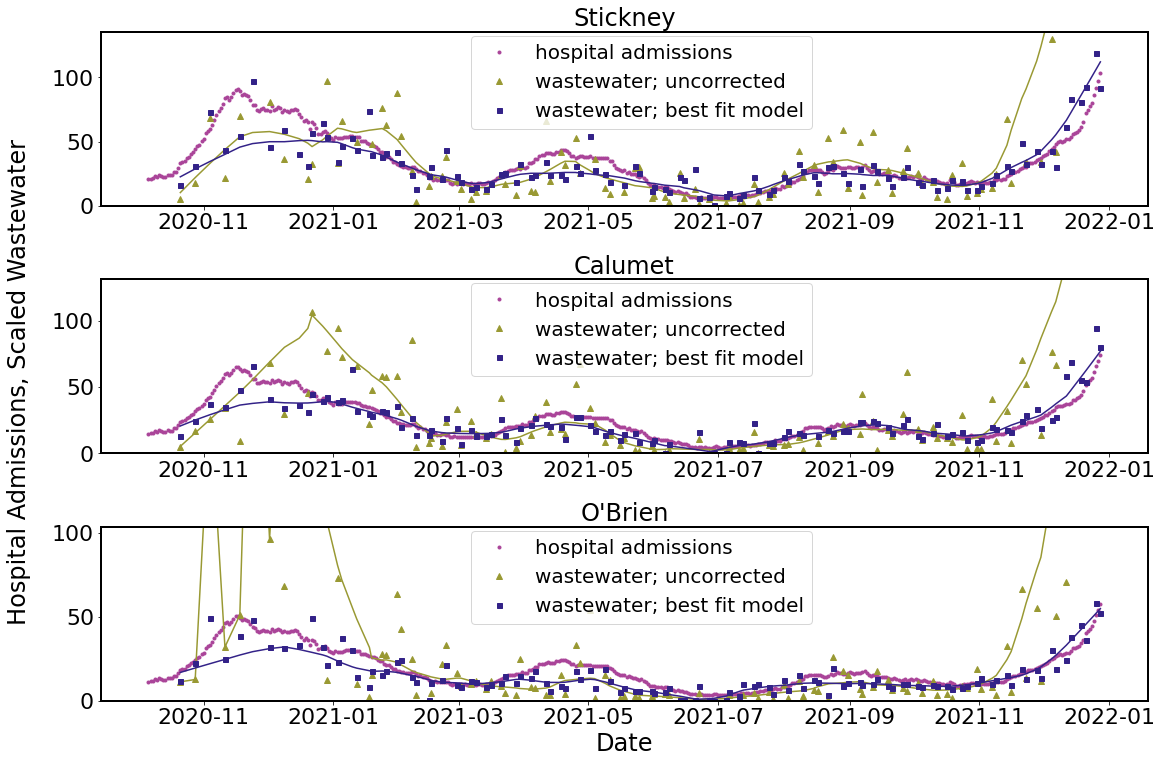

In [12]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels & titles
fs3 = 20 # legend
fig = plt.figure(figsize=(16,11))
mycolors = ['#AA4499','#999933','#332288','#88CCEE']
for j,catch in enumerate(catches_shortlist):
    plt.subplot(len(catches_shortlist),1,j+1)
    ax = plt.gca()
    startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
    enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
    maskp = (prevdf.catchment==catch) & (prevdf.date>=startdate) & (prevdf.date<=enddate)
    maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate)
    p = ax.plot(prevdf[maskp].date,prevdf[maskp][useprev_single],'.',color=mycolors[0],label=useprev_single.replace('sensitive','hospital'))
    ws = []
    for n,(ww,label) in enumerate(zip(usewws,['uncorrected','best fit model'])):
        ws = ax.plot(wbe[maskw].date,wbe[maskw][ww],marks[np.mod(n+1,3)],
                markersize=msize[np.mod(n+1,3)],color=mycolors[n+1],label='wastewater; '+label)
        smooth = sm.nonparametric.lowess(endog=wbe[maskw][ww], exog=mdates.date2num(wbe[maskw].date), frac= 0.1)
        ax.plot(smooth[:,0],smooth[:,1],'-',color=mycolors[n+1])
        p+=ws
        ax.set_ylim([0,ax.get_ylim()[1]/2])
        ax.xaxis.set_tick_params(labelsize=fs1)
        ax.yaxis.set_tick_params(labelsize=fs1)
        labs = [l.get_label() for l in p]
        ax.legend(p,labs,bbox_to_anchor=(.35,1),loc='upper left',borderaxespad=.2,fontsize=fs3)
        ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
ax.set_xlabel('Date',fontsize=fs2)
fig.text(-.02, 0.5, 'Hospital Admissions, Scaled Wastewater', va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()

Using lag = 2


catchment  Raw SARS-CoV-2  Corrected Wastewater
0  Stickney               3                     2
1   Calumet               7                     5
2    OBrien               7                     7
3      Egan               6                     6
4   Hanover              10                     8
5     Kirie              -1                    -5
6    Lemont              12                     8

catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.7447                0.8229    0.0950
1   Calumet          0.6853                0.8075    0.1513
2    OBrien          0.7139                0.7808    0.0857
3      Egan          0.7609                0.7894    0.0361
4   Hanover          0.5446                0.5273   -0.0328
5     Kirie          0.8001                0.8256    0.0309
6    Lemont          0.4644                0.7453    0.3769

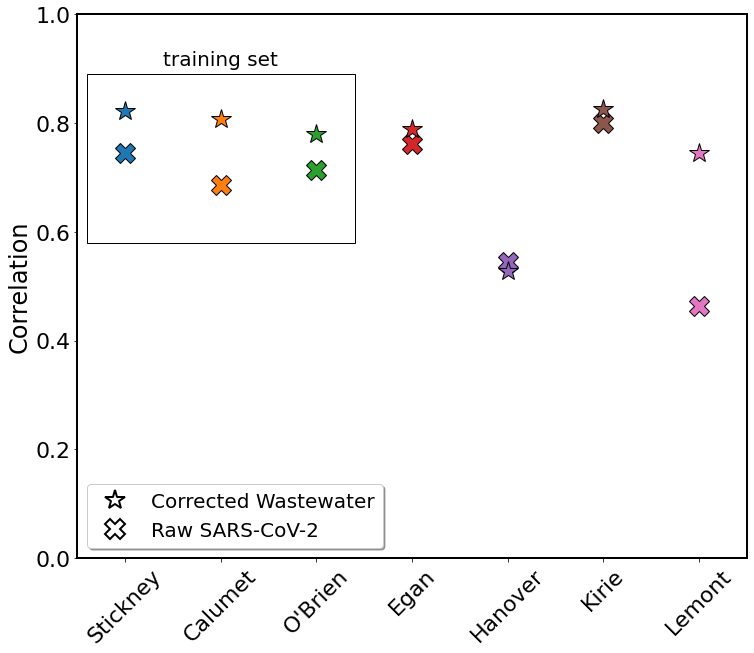

In [13]:
fs1 = 22 # tick labels 
fs2 = 24 # axis label
fs3 = 20 # legend & training annotation
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']

uselags = np.arange(-10,10,1)
show_corr_plot=False
box = [-.4,.58,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[useprev_single]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',useprev_single]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[useprev_single] = np.log10(pdf[useprev_single])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[useprev_single])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[useprev_single],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[useprev_single])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
# fig,ax = plt.subplots(figsize=(8,5))
fig,ax = plt.subplots(figsize=(12,10))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
if box!=None:
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate('training set',xy=(1,1),xycoords='figure fraction',
                   xytext=(1, .9), textcoords='data',
                   horizontalalignment='center',verticalalignment='bottom',fontsize=fs3)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45,fontsize=fs1)
ax.yaxis.set_tick_params(labelsize=fs1)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation',fontsize=fs2)
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=fs3)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

45.282621563405456 57.46834516704254 66.83267788609734
41.06059185188724 65.2628388456634 68.30519197891374
57.94392277457473 27.019992030155663 25.65827701238686
59.703424219371186 4.672421230391592 5.896815575649953


/tmp/ipykernel_15994/1670221701.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([modtermdict[mod[4:-4]] for mod in np.array(aic2[mask].model)[np.r_[modelorder]]],rotation=90,fontsize=fs1)
/tmp/ipykernel_15994/1670221701.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_ins.set_xticklabels([modtermdict[mod[4:-4]].replace(' ','\n') for mod in models[7:]],rotation=90,fontsize=fs4)


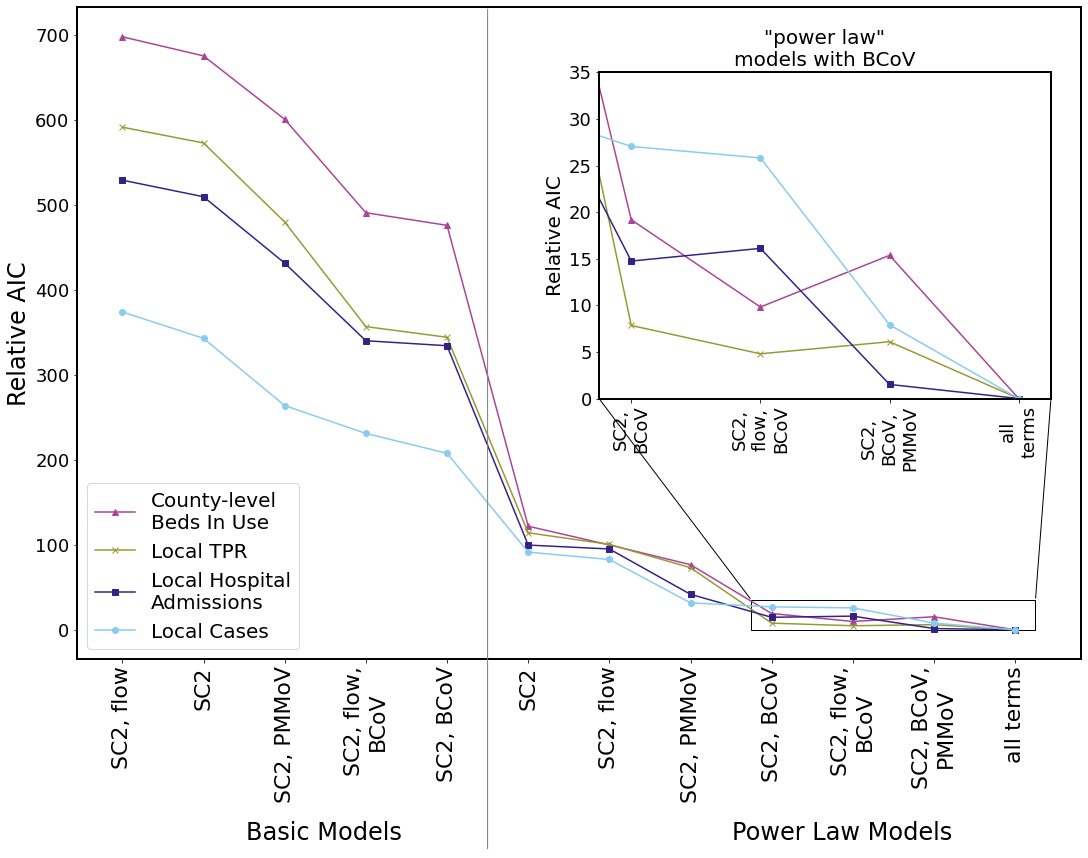

In [14]:
fs1 = 22 # big ticks
fs2 = 24 # big labels
fs3 = 20 # legend
fs4 = 18 # small ticks
fs5 = 20 # small labels & title
modtermdict = {'no correction':'SC2',
               'only flow':'SC2, flow',
               'pmmov norm':'SC2, PMMoV', 
               'only bcov norm':'SC2, BCoV',
               'bcov flow norm':'SC2, flow,\nBCoV',
               'pmmov bcov norm':'SC2, BCoV,\nPMMoV',
               'pm bc fl':'all terms'}
prevnamedict = {'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'hospital admissions':'Local Hospital\nAdmissions',
 'Cook County beds in use':'County-level\nBeds In Use'}
prevwwlagdict = {'positive tests':-3,
                'test positivity rate':-2,
                'hospital admissions':2,
                'Cook County beds in use':-2}

marks = ['^','x','s','o']
mycolors = ['#AA4499','#999933','#332288','#88CCEE']

fig = plt.figure(figsize=(18,12))
modelorder = [2,0,4,8,6,1,3,5,7,9,11,13]
theseprev = ['Cook County beds in use','test positivity rate','hospital admissions','positive tests']
for p,prev in enumerate(theseprev):
    mylag = prevwwlagdict[prev]
    mask = (aic2.prevind==prev) & (aic2.wwtp=='comb') & (aic2.lag==mylag)
    plt.plot(np.array(aic2[mask].model)[np.r_[modelorder]],
             np.array(aic2[mask].aic-np.min(aic2[mask].aic))[np.r_[modelorder]],marks[p]+'-',color=mycolors[p],label=prevnamedict[prev])
    aiclist = np.array(aic2[mask].aic-np.min(aic2[mask].aic))[np.r_[modelorder]]
    print(aiclist[5]-aiclist[7],aiclist[7]-aiclist[8],aiclist[7]-aiclist[9])
ax = plt.gca()
ax.add_patch(Rectangle((7.75,0), 3.5, 35, fill=None, alpha=1))
ylim = ax.get_ylim()
ax.annotate('', xy = (4.5, ylim[-1]), xycoords='data',
                    xytext = (4.5, -260), textcoords='data',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )
plt.annotate('Basic Models',xy=(1,1),xycoords='figure fraction',
               xytext=(.25, .015), textcoords='figure fraction',
               horizontalalignment='center',verticalalignment='bottom',fontsize=fs2)
plt.annotate('Power Law Models',xy=(1,1),xycoords='figure fraction',
               xytext=(.65, .015), textcoords='figure fraction',
               horizontalalignment='center',verticalalignment='bottom',fontsize=fs2)
plt.legend(loc='lower left',fontsize=fs3)
ax.set_xticklabels([modtermdict[mod[4:-4]] for mod in np.array(aic2[mask].model)[np.r_[modelorder]]],rotation=90,fontsize=fs1)
plt.ylabel('Relative AIC',fontsize=fs2)
plt.yticks(fontsize=18)
plt.xlabel(' ')
inset = (.52,.4,.45,.5)
ax_ins = inset_axes(ax, width="100%", height="100%",bbox_to_anchor=inset,bbox_transform=ax.transAxes, loc=3, borderpad=0)
for p,prev in enumerate(theseprev):
    mylag = prevwwlagdict[prev]
    mask = (aic2.prevind==prev) & (aic2.wwtp=='comb') & (aic2.lag==mylag)
    plt.plot(np.array(aic2[mask].model)[np.r_[5,7,9,11,13]],
             np.array(aic2[mask].aic-np.min(aic2[mask].aic))[np.r_[5,7,9,11,13]],marks[p]+'-',color=mycolors[p],label=prevnamedict[prev])
plt.ylabel('Relative AIC',fontsize=fs5)
ax_ins.yaxis.set_tick_params(labelsize=fs4)
ax_ins.set_xlim([0.75,4.25])
ax_ins.set_title("\"power law\"\nmodels with BCoV",fontsize=fs5)
ax_ins.set_ylim([0,35])
ax_ins.set_xticklabels([modtermdict[mod[4:-4]].replace(' ','\n') for mod in models[7:]],rotation=90,fontsize=fs4)

ax.annotate('', xy = (7.75, 35), xycoords='data',
                    xytext = (0.52, .4), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="-") )
ax.annotate('', xy = (11.25, 35), xycoords='data',
                    xytext = (0.97, 0.4), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="-") )
plt.show()

# Supplement

In [15]:
useparams = []
checkprevs = ['positive tests','test positivity rate','hospital admissions','Cook County beds in use']
for prev in checkprevs:
    mask = (aic2.prevind==prev) & (aic2.wwtp=='comb') & (aic2.model.isin(models[-4:]))
    print(prev)
    ps = np.unique(list(aic2[mask & (aic2.aic-np.min(aic2[mask].aic.values)<10)].lag.values))
    print(ps)
    useparams.append(ps)
    print(str(np.unique(list(aic2[mask & (aic2.aic-np.min(aic2[mask].aic.values)<4)].lag.values)))[1:-1])
    print(str(np.unique(list(aic2[mask & (aic2.aic-np.min(aic2[mask].aic.values)<10)].lag.values)))[1:-1])
print(useparams)

positive tests
[-7 -6 -5 -4 -3 -2 -1]
-6 -5 -4 -3 -2
-7 -6 -5 -4 -3 -2 -1
test positivity rate
[-2]
-2
-2
hospital admissions
[-10  -9  -8  -7  -6  -5   2]
-7  2
-10  -9  -8  -7  -6  -5   2
Cook County beds in use
[-3 -2 -1  0  1]
-2 -1  0
-3 -2 -1  0  1
[array([-7, -6, -5, -4, -3, -2, -1]), array([-2]), array([-10,  -9,  -8,  -7,  -6,  -5,   2]), array([-3, -2, -1,  0,  1])]


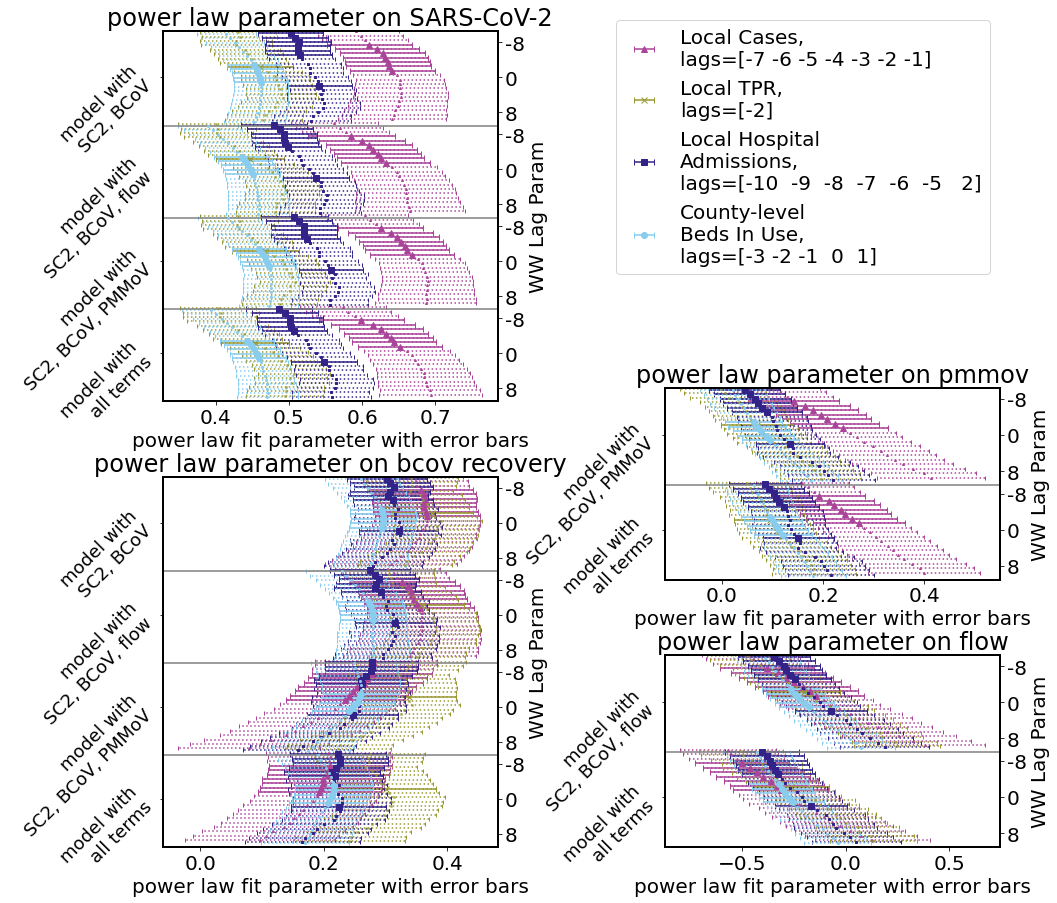

In [16]:
plus0 = 21*len(checkprevs)
lastprev = len(checkprevs)-1
modtermdict2 = {'raw_data':'SC2',
               'only_flow_norm':'SC2, flow',
               'pmmov_norm':'SC2, PMMoV', 
               'only_bcov_norm':'SC2, BCoV',
               'bcov_flow_norm':'SC2, BCoV, flow',
               'pmmov_bcov_norm':'SC2, BCoV, PMMoV',
               'pmmov_bcov_flow_norm':'all terms'}
prevnamedict = {'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'hospital admissions':'Local Hospital\nAdmissions',
 'Cook County beds in use':'County-level\nBeds In Use'}
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(10, 2, figure=fig,hspace=5.5,wspace=.5)
mycolors = ['#AA4499','#999933','#332288','#88CCEE']
marks = ['^','x','s','o']
for (feature,fits,sign) in zip(['bcov_recovery','pmmov','flow','raw_data'],[[7,9,11,13],[11,13],[9,13],[7,9,11,13]],[-1,-1,1,1]):
    if feature == 'raw_data':
        ax = fig.add_subplot(gs[:5, 0])
    elif feature == 'bcov_recovery':
        ax = fig.add_subplot(gs[5:, 0])
    elif feature == 'pmmov':
        ax = fig.add_subplot(gs[4:7, 1])
    elif feature == 'flow':
        ax = fig.add_subplot(gs[7:, 1])
#     print(feature)
    p0 = 0
    splits = []
    for n,myfit in enumerate(paramdf.fit.unique()[np.r_[fits]]):
#         plus = 0
#         print(myfit)
        for m,(prevind,mylags) in enumerate(zip(checkprevs,useparams)):
            mask = (paramdf.wwtp=='comb') & (paramdf.fit==myfit) & (
                paramdf.lag.isin(mylags)) & (paramdf.feature==feature) & (
                paramdf.prevind==prevind)
            mask1 = (paramdf.wwtp=='comb') & (paramdf.fit==myfit) & (
                paramdf.feature==feature) & (paramdf.prevind==prevind)
            if feature=='raw_data':
                if (n==0) & (m==lastprev):
                    lab = prevnamedict[prevind]+',\nlags='+str(mylags)
                elif n==0:
                    lab = prevnamedict[prevind]+',\nlags='+str(mylags)
                else:
                    lab=None
            else:
                lab=None
            eb1 = plt.errorbar(paramdf[mask1].params*sign,-10-np.array(lags)-p0-.2*m,
                                 xerr=[(paramdf[mask1].params-paramdf[mask1].lb)*sign,
                                       (paramdf[mask1].ub-paramdf[mask1].params)*sign],
                                 capsize=2,fmt = marks[m],color=mycolors[m],markersize=2)
            eb1[-1][0].set_linestyle(':')
            ax.errorbar(paramdf[mask].params*sign,-10-np.array(mylags)-p0-.2*m,
                                 xerr=[(paramdf[mask].params-paramdf[mask].lb)*sign,
                                       (paramdf[mask].ub-paramdf[mask].params)*sign],
                                 capsize=3,fmt = marks[m],color=mycolors[m],label=lab,markersize=6)
        p0+=len(lags)
        splits.append(p0)
    xlims = plt.gca().get_xlim()
    plt.gca().set_ylim([-p0-.5, 0])
    for p in splits:
        plt.hlines(y=-p-.5,xmin=xlims[0],xmax=xlims[1],color='tab:grey')
    plt.gca().set_xlim(xlims)
    plt.title('power law parameter on '+feature.replace('raw_data','SARS-CoV-2').replace('_',' '))
    plt.xlabel('power law fit parameter with error bars')
    plt.gca().set_yticks(10.5-np.array(splits),
                         ['model with\n'+modtermdict2[mod] for mod in paramdf.fit.unique()[np.r_[fits]]],
                         rotation=45,fontsize=18)
    ax = plt.gca().twinx()

    ax.set_ylim([-p0-.5,0])
    ax.set_yticks([s-10.5-21*s1 for s1 in range(n,-1,-1) for s in [-8,0,8]],
                  [s for s1 in range(n,-1,-1) for s in [8,0,-8]])
    ax.set_ylabel('WW Lag Param')
fig.legend(loc='upper right',bbox_to_anchor=(.9,.9))
plt.show()

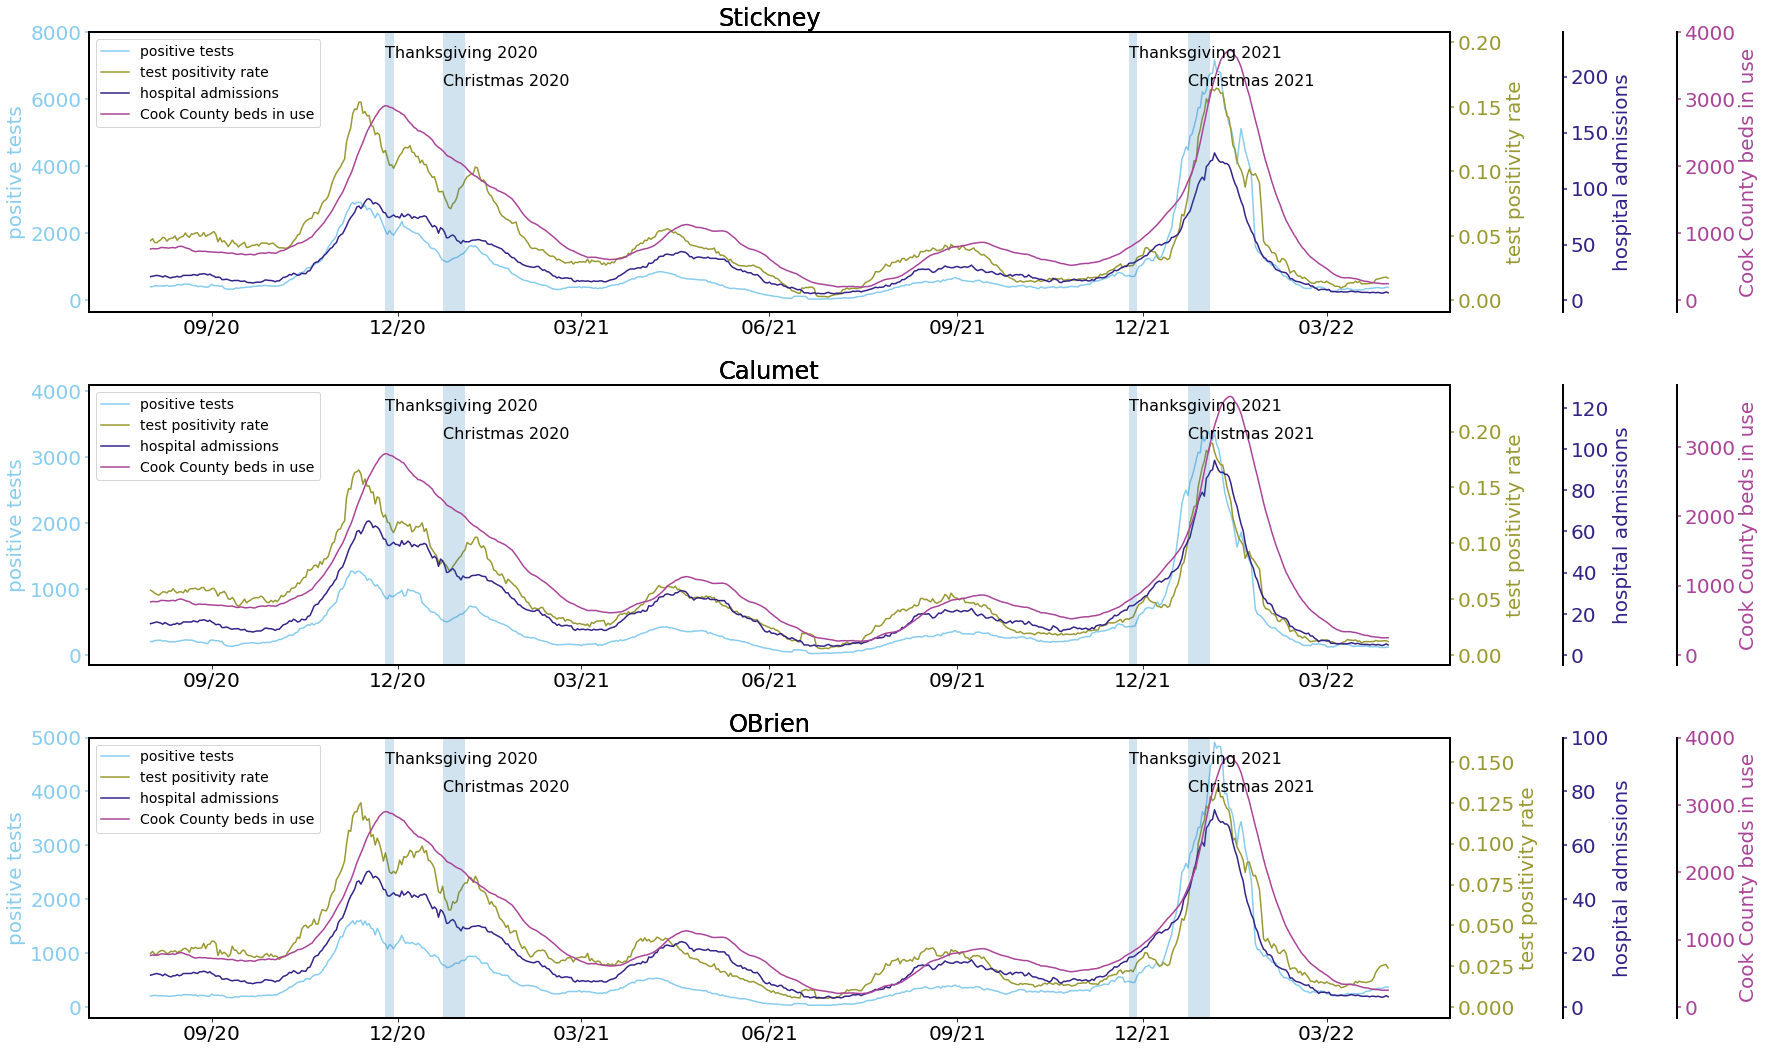

In [17]:
useprevs = ['test positivity rate','hospital admissions','Cook County beds in use']
plt.figure(figsize=(25,15))
tkw = dict(size=4, width=1.5)
startdate = '2020-08-01'
ylims = [[-350,8000],[-150,4100],[-200,5000]]
ylimmult = [[2.6e-5,0.03,0.5],[5.9e-5,0.032,0.95],[3.3e-5,0.02,0.8]]
plotlags = [0,0,0]
mycolors = ['#88CCEE','#999933','#332288','#AA4499']
marks = ['^','x','s','o']
for n,catch in enumerate(catches_shortlist):
    plt.subplot(len(catches_shortlist),1,n+1)
    ax1 = plt.gca()
    mask = (prevdf.catchment == catch) & (prevdf.date>startdate) & (prevdf.date<='2022-04-05')
    w1 = ax1.plot(prevdf[mask].date,prevdf[mask]['positive tests'],label='positive tests',color=mycolors[0])
    ax1.set_ylabel('positive tests')
    ax1.yaxis.label.set_color(mycolors[0])
    ax1.tick_params(axis='y', colors=mycolors[0], **tkw)
    ax1.set_ylim(ylims[n])
    for m,(col,lag) in enumerate(zip(useprevs,plotlags)):
        enddate = '2022-04-05'
        ax = ax1.twinx()
        mask = (prevdf.catchment == catch) & (prevdf.date>startdate) & (prevdf.date<=enddate)
        p=ax.plot(prevdf[mask].date-datetime.timedelta(days=lag),prevdf[mask][col],color=mycolors[m+1],label=col)
        w1+=p
        ax.set_ylabel(col)
        ax.set_title(catch)
        ax.yaxis.label.set_color(p[0].get_color())
        ax.tick_params(axis='y', colors=p[0].get_color(), **tkw)
        ax.spines['right'].set_position(("axes", 1+m/12))
        ax.set_ylim([p*ylimmult[n][m] for p in ylims[n]])
    h = ax.get_ylim()
    for p,(s,e,name) in enumerate(zip(['2020-11-25','2020-12-23','2021-11-24','2021-12-23'],
                     ['2020-11-29','2021-01-03','2021-11-28','2022-01-03'],
                     ['Thanksgiving 2020','Christmas 2020','Thanksgiving 2021','Christmas 2021'])):
        ax.axvspan(s,e,alpha=0.2)
        ax.annotate(name,xy=(pd.to_datetime(s, format = '%Y-%m-%d'), h[0]+(.95-.1*np.mod(p,2))*(h[1]-h[0])), xycoords='data',
                    xytext=(pd.to_datetime(s, format = '%Y-%m-%d'), h[0]+(.95-.1*np.mod(p,2))*(h[1]-h[0])), textcoords='data',
                    arrowprops=dict(facecolor='tab:red', shrink=0.05),
                    horizontalalignment='left', verticalalignment='top',fontsize=16)
    ax.set_title(catch)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(DateFormatter("%m/%y"))
    labs = [l.get_label() for l in w1]
    plt.legend(w1,labs,fontsize=14,loc='upper left')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

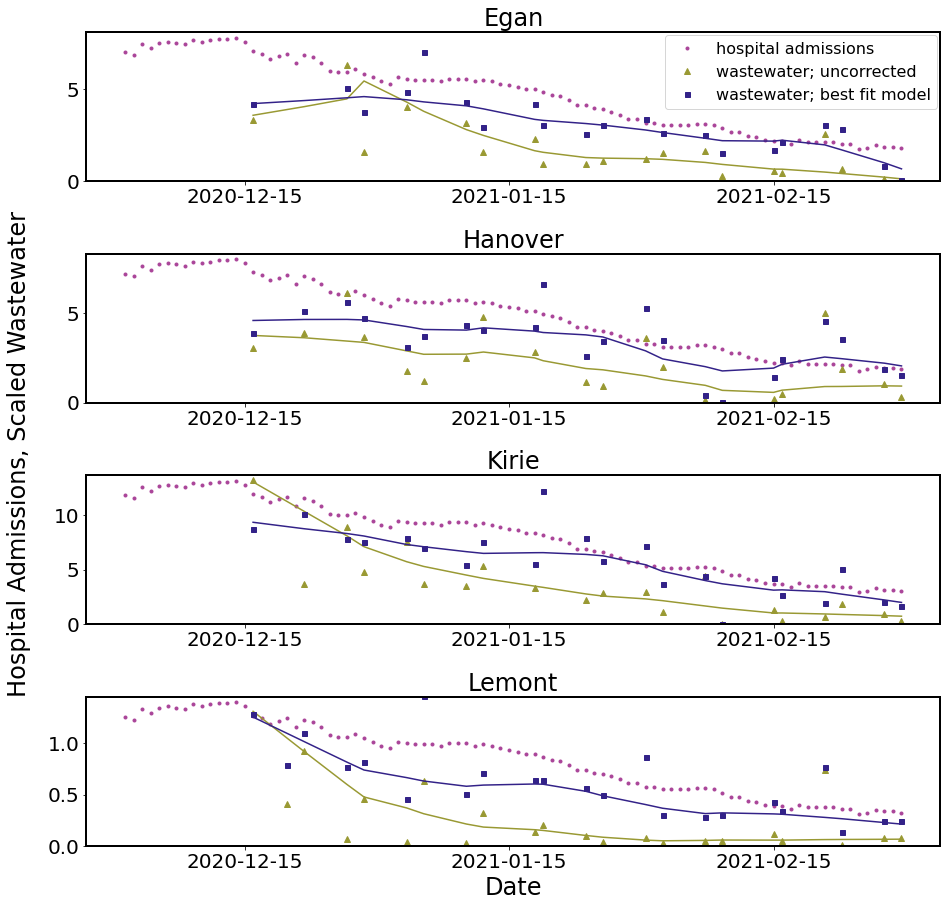

In [18]:
marks = ['o','^','s']
msize = [5,6,5]
mycolors = ['#AA4499','#999933','#332288','#88CCEE']
fig = plt.figure(figsize=(13,1+len(['Egan','Hanover','Kirie','Lemont'])*3))
for j,catch in enumerate(['Egan','Hanover','Kirie','Lemont']):
    plt.subplot(len(['Egan','Hanover','Kirie','Lemont']),1,j+1)
    ax = plt.gca()
    startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
    enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
    maskp = (prevdf.catchment==catch) & (prevdf.date>=startdate) & (prevdf.date<=enddate)
    maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate)
    p = ax.plot(prevdf[maskp].date,prevdf[maskp][useprev_single],'.',color=mycolors[0],label=useprev_single.replace('sensitive','hospital'))
    ax1 = ax
    ws = []
    for n,(ww,label) in enumerate(zip(usewws,['uncorrected','best fit model'])):
        ax1.set_ylim([0,ax1.get_ylim()[1]])
        datax = wbe[(wbe.catchment==catch)][['date',ww]].copy()
        dataz = prevdf[(prevdf.catchment==catch)][['date','hospital admissions']].copy()
        dataz.date -= datetime.timedelta(days=5)
        mydf2 = pd.merge(datax,dataz,on=['date'],how='inner')
        mydf2.dropna(how='any',inplace=True)
        features = mydf2[(mydf2.date<enddate)][ww]
        target = mydf2[(mydf2.date<enddate)]['hospital admissions']
        f2,reg = mymreg(features,target,addconst=0)
        ws = ax1.plot(wbe[maskw].date,wbe[maskw][ww]*reg.params[0],marks[np.mod(n+1,3)],
                markersize=msize[np.mod(n+1,3)],color=mycolors[n+1],label='wastewater; '+label)
        smooth = sm.nonparametric.lowess(endog=wbe[maskw][ww]*reg.params[0], exog=mdates.date2num(wbe[maskw].date), 
                                         frac= 0.4)
        ax1.plot(smooth[:,0],smooth[:,1],'-',color=mycolors[n+1])
        p+=ws
    if j==0:
        labs = [l.get_label() for l in p]
        ax.legend(p,labs,bbox_to_anchor=(1,1),loc='upper right',borderaxespad=.2,ncol=1,fontsize=16)
    ax.set_title(catch.replace('OBrien',"O'Brien"))
    ax.set_xticks(ax.get_xticks()[1::2])
ax.set_xlabel('Date',fontsize=fs2)
fig.text(-.02, 0.5, 'Hospital Admissions, Scaled Wastewater', va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()

Using lag = 0


catchment  Raw SARS-CoV-2  Corrected Wastewater
0  Stickney              10                     9
1   Calumet              11                    11
2    OBrien              13                    15
3      Egan              13                    13
4   Hanover              11                    11
5     Kirie               2                     1
6    Lemont              19                     9

catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.7464                0.8360    0.1072
1   Calumet          0.7009                0.8233    0.1487
2    OBrien          0.7511                0.8118    0.0748
3      Egan          0.7543                0.7841    0.0380
4   Hanover          0.5666                0.5409   -0.0475
5     Kirie          0.8077                0.8247    0.0206
6    Lemont          0.4855                0.7545    0.3565

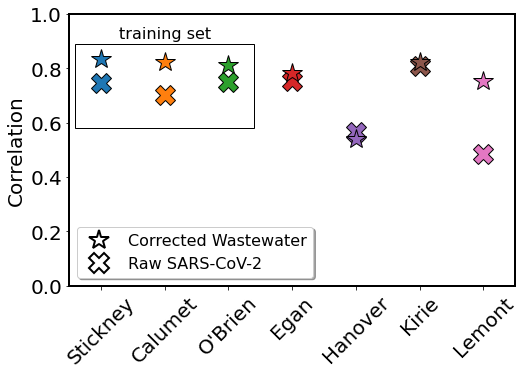

In [19]:
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']
altprev = 'Cook County beds in use'
uselags = np.arange(-10,10,1)
show_corr_plot=False
box = [-.4,.58,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[altprev]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',altprev]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[altprev] = np.log10(pdf[altprev])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors0[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(8,5))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
if box!=None:
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate('training set',xy=(1,1),xycoords='figure fraction',
                   xytext=(1, .9), textcoords='data',
                   horizontalalignment='center',verticalalignment='bottom',fontsize=16)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],rotation=45)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation')
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

Using lag = 0


catchment  Raw SARS-CoV-2  Corrected Wastewater
0  Stickney               6                     3
1   Calumet               8                     1
2    OBrien              12                     9
3      Egan              11                     1
4   Hanover              -7                    -7
5     Kirie              -4                    -3
6    Lemont              -6                    -4

catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.6427                0.7596    0.1539
1   Calumet          0.5799                0.7297    0.2053
2    OBrien          0.6404                0.7380    0.1322
3      Egan          0.6944                0.7256    0.0430
4   Hanover          0.4870                0.4668   -0.0433
5     Kirie          0.7710                0.7928    0.0275
6    Lemont          0.4485                0.6921    0.3520

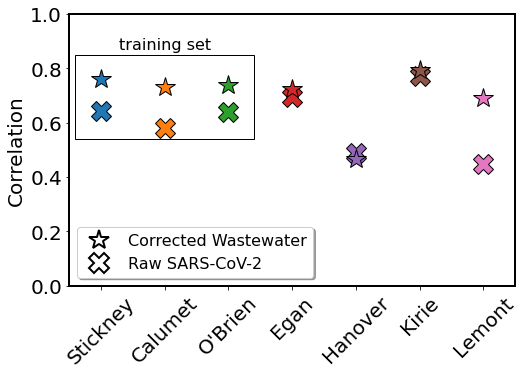

In [20]:
altprev = 'test positivity rate'
uselags = np.arange(-10,10,1)
show_corr_plot=False
box = [-.4,.54,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[altprev]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',altprev]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[altprev] = np.log10(pdf[altprev])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(8,5))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
if box!=None:
#         ax.add_patch(Rectangle((-0.4,0.58), 2.8, 0.31, fill=None, alpha=1))
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate('training set',xy=(1,1),xycoords='figure fraction',
                   xytext=(1, .86), textcoords='data',
                   horizontalalignment='center',verticalalignment='bottom',fontsize=16)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],rotation=45)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation')
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

Using lag = 0


catchment  Raw SARS-CoV-2  Corrected Wastewater
0  Stickney              -1                    -2
1   Calumet              -4                    -3
2    OBrien              -3                     1
3      Egan               7                     7
4   Hanover               7                     9
5     Kirie               2                   -10
6    Lemont             -10                    -8

catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.7533                0.8176    0.0786
1   Calumet          0.6918                0.7942    0.1289
2    OBrien          0.7250                0.7916    0.0841
3      Egan          0.6785                0.7091    0.0432
4   Hanover          0.5219                0.4711   -0.1078
5     Kirie          0.8147                0.8322    0.0210
6    Lemont          0.4582                0.5394    0.1505

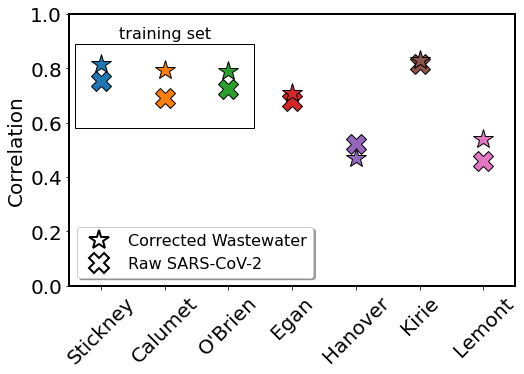

In [21]:
altprev = 'positive tests'
uselags = np.arange(-10,10,1)
show_corr_plot=False
box = [-.4,.58,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[altprev]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',altprev]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[altprev] = np.log10(pdf[altprev])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(8,5))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
if box!=None:
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate('training set',xy=(1,1),xycoords='figure fraction',
                   xytext=(1, .9), textcoords='data',
                   horizontalalignment='center',verticalalignment='bottom',fontsize=16)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],rotation=45)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation')
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

## Training and Testing

wbe has the uncorrected and the best fit trained on everything.   
Make another one that has the best fit trained on less.  

Using lag = 0


catchment  Raw SARS-CoV-2  Corrected Wastewater  Trained on Less
0  Stickney               4                     4                4
1   Calumet               3                    -1               -1
2    OBrien               3                     8               11
3      Egan              -7                    -7               -7
4   Hanover              -7                    -7               -7
5     Kirie              -7                    -7               -7
6    Lemont              -7                    -7               -7

catchment  Raw SARS-CoV-2  Corrected Wastewater  Trained on Less  \
0  Stickney          0.8430                0.9096           0.8837   
1   Calumet          0.8041                0.8812           0.8485   
2    OBrien          0.8438                0.8473           0.8424   
3      Egan             NaN                   NaN              NaN   
4   Hanover             NaN                   NaN              NaN   
5     Kirie             NaN                   NaN              NaN   
6    Lemont             NaN                   NaN              NaN   

   % change full over none  % change partial over none  \
0                   0.0732                      0.0461   
1                   0.0875                      0.0523   
2                   0.0041                     -0.0017   
3                      NaN                         NaN   
4                      NaN                         NaN   
5                      NaN                         NaN   
6                      NaN                         NaN   

   % change full over partial  
0                      0.0285  
1                      0.0371  
2                      0.0058  
3                         NaN  
4                         NaN  
5                         NaN  
6                         NaN

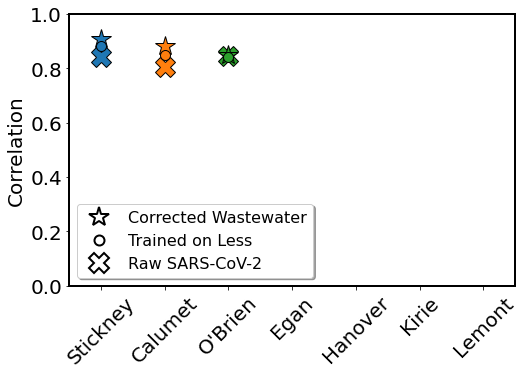

In [22]:
altprev = 'hospital admissions'
uselags = np.arange(-10,10,1)
show_corr_plot=False
# fullstart = '2020-10-01'
# fullend = '2022-01-01'
# fullstart = '2020-10-01'
# fullend = '2021-08-01'
fullstart = '2021-08-01'
fullend = '2022-01-01'
box = [-.4,.58,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[altprev]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (
            wbe.orig_raw>ww_lod) & (wbe.date>=fullstart) & (wbe.date<fullend)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',altprev]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[altprev] = np.log10(pdf[altprev])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)

label = 'Trained on Less'
mylag = []
mycorr = []
for n,catch in enumerate(catches_correlation):
    startdate = wbe_early[(wbe_early.catchment==catch) & (wbe_early.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
    enddate = wbe_early[(wbe_early.catchment==catch) & (wbe_early.date<=prevdf.date.max())].date.max()
    maskp = (prevdf.catchment==catch) & (prevdf[altprev]>0)
    maskw = (wbe_early.catchment==catch) & (wbe_early.date>=startdate) & (wbe_early.date<=enddate) & (
        wbe_early.orig_raw>ww_lod) & (wbe_early.date>=fullstart) & (wbe_early.date<fullend)
    wdf = wbe_early[maskw][['date',ww]].copy()
    pdf = prevdf[maskp][['date',altprev]].copy()
    wdf[ww] = np.log10(wdf[ww])
    pdf[altprev] = np.log10(pdf[altprev])
    mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev])
    if show_corr_plot:
        plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors[n],label=catch+', '+ww)
    mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
    mycorr.append(mycors[uselags==lag])
mylags[label] = np.round(mylag,4)
mycorrs[label] = np.round(mycorr,4)

mycorrs['% change full over none'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
mycorrs['% change partial over none'] = np.round((mycorrs[label]-mycorrs[wwlabs[0]])/mycorrs[label],4)
mycorrs['% change full over partial'] = np.round((mycorrs[wwlabs[1]]-mycorrs[label])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(8,5))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs+[label],['X','*','.']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'.',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=label)
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],rotation=45)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation')
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

## Plot parameters with errorbars

In [23]:
display(paramdf[(paramdf.wwtp=='comb') & (paramdf.prevind=='hospital admissions') & (paramdf.lag==2) & (paramdf.fit=='pmmov_bcov_flow_norm')])
display(paramearlydf[(paramearlydf.wwtp=='comb') & (paramearlydf.prevind=='hospital admissions') & (paramearlydf.lag==2) & (paramearlydf.fit=='pmmov_bcov_flow_norm')])


wwtp              prevind                   fit        feature  lag  \
3051  comb  hospital admissions  pmmov_bcov_flow_norm       raw_data    2   
3052  comb  hospital admissions  pmmov_bcov_flow_norm           flow    2   
3053  comb  hospital admissions  pmmov_bcov_flow_norm  bcov_recovery    2   
3054  comb  hospital admissions  pmmov_bcov_flow_norm          pmmov    2   
3055  comb  hospital admissions  pmmov_bcov_flow_norm       Stickney    2   
3056  comb  hospital admissions  pmmov_bcov_flow_norm        Calumet    2   
3057  comb  hospital admissions  pmmov_bcov_flow_norm         OBrien    2   

        params        lb        ub  
3051  0.548015  0.503337  0.592694  
3052 -0.166016 -0.341584  0.009552  
3053 -0.224141 -0.300610 -0.147671  
3054 -0.151146 -0.220795 -0.081497  
3055  0.143969 -0.839049  1.126987  
3056 -0.060087 -0.981583  0.861410  
3057 -0.266004 -1.180278  0.648270

wwtp              prevind                   fit        feature  lag  \
3051  comb  hospital admissions  pmmov_bcov_flow_norm       raw_data    2   
3052  comb  hospital admissions  pmmov_bcov_flow_norm           flow    2   
3053  comb  hospital admissions  pmmov_bcov_flow_norm  bcov_recovery    2   
3054  comb  hospital admissions  pmmov_bcov_flow_norm          pmmov    2   
3055  comb  hospital admissions  pmmov_bcov_flow_norm       Stickney    2   
3056  comb  hospital admissions  pmmov_bcov_flow_norm        Calumet    2   
3057  comb  hospital admissions  pmmov_bcov_flow_norm         OBrien    2   

        params        lb        ub  
3051  0.507838  0.446360  0.569315  
3052 -0.413592 -0.666765 -0.160420  
3053 -0.236951 -0.349847 -0.124055  
3054 -0.135389 -0.229325 -0.041453  
3055  0.830761 -0.589647  2.251170  
3056  0.543972 -0.788172  1.876116  
3057  0.309020 -1.010621  1.628660

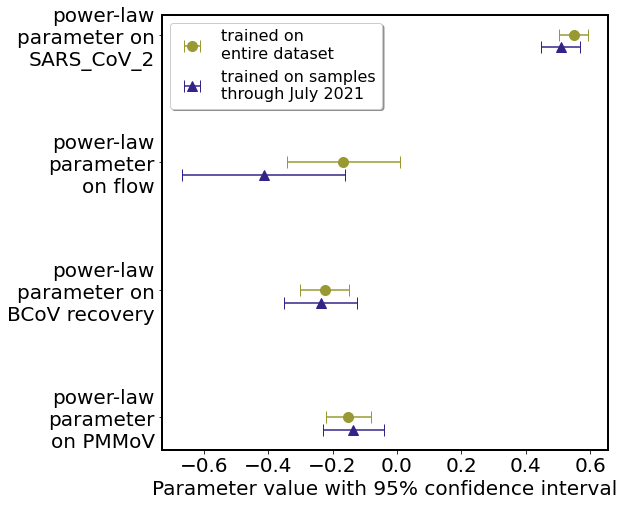

In [24]:
plt.figure(figsize=(8,8))
ax = plt.gca()
mycolors = ['#AA4499','#999933','#332288','#88CCEE']
modtermdict2 = {'raw_data':'power-law\nparameter on\nSARS_CoV_2',
               'flow':'power-law\nparameter\non flow',
               'bcov_recovery':'power-law\nparameter on\nBCoV recovery', 
               'pmmov':'power-law\nparameter\non PMMoV'}
for m,(mdf,lab,mark) in enumerate(zip([paramdf,paramearlydf],
                                      ['trained on\nentire dataset','trained on samples\nthrough July 2021'],
                                      ['o','^'])):
    mask = (mdf.wwtp=='comb') & (mdf.prevind=='hospital admissions') & (mdf.lag==2) & (
        mdf.fit=='pmmov_bcov_flow_norm') & (mdf.feature.isin(['raw_data','flow','bcov_recovery','pmmov']))
    ax.errorbar(mdf[mask].params,3-np.arange(4)-m/10,
                 xerr=[mdf[mask].params-mdf[mask].lb,mdf[mask].ub-mdf[mask].params],
             capsize=6,fmt =mark,color=mycolors[m+1],markersize=10,label=lab)
ax.set_yticks(range(4))
ax.set_yticklabels([modtermdict2[m] for m in mdf[mask].feature][::-1])
ax.set_xlabel('Parameter value with 95% confidence interval')
ledge = plt.legend(loc='upper left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)
plt.show()

In [25]:
aicfulldf.info()
aicdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   wwtp     1176 non-null   object 
 1   prevind  1176 non-null   object 
 2   fit      1176 non-null   object 
 3   lag      1176 non-null   int64  
 4   aic      1176 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   wwtp     1176 non-null   object 
 1   prevind  1176 non-null   object 
 2   fit      1176 non-null   object 
 3   lag      1176 non-null   int64  
 4   aic      1176 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.1+ KB


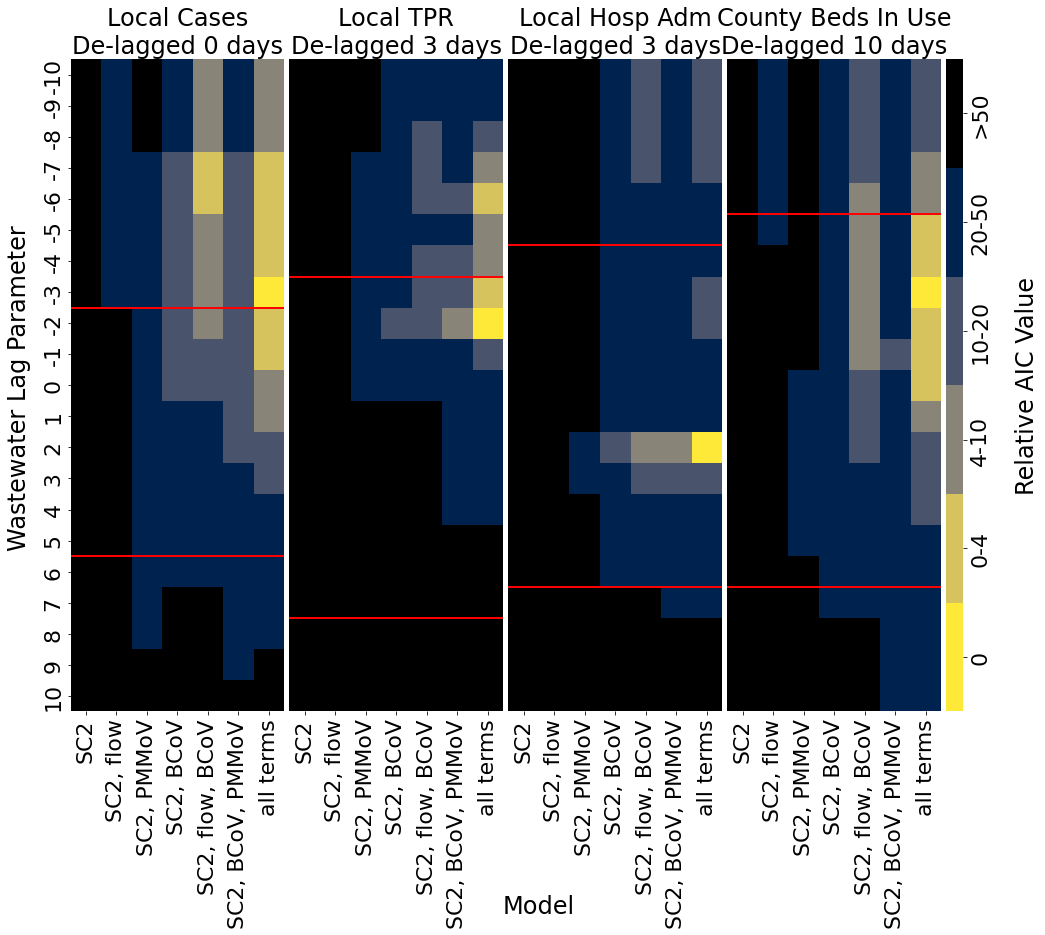

In [26]:
aic2,param2,models = reformat_aic_params(aicfulldf[['wwtp','prevind','fit','lag','aic']],paramearlydf,trymodels)
fs1 = 22 # tick labels
fs2 = 24 # axis labels & axis titles
aicprevs = ['positive tests','test positivity rate','hospital admissions','Cook County beds in use']
# aic_heatmap_single(aic2,models,'comb',aicprevs,prevbounds,prevlagdict,fs1=16,fs2=18)
# def aic_heatmap_single(aic2,models,wwtp,useprevs,prevbounds,prevlagdict,fs1=16,fs2=18):
aic2.prevind=pd.Categorical(aic2.prevind,categories=aic2.prevind.unique(),ordered=True)
aic2.model=pd.Categorical(aic2.model,categories=aic2.model.unique(),ordered=True)
pivotedaic = aic2[(aic2.model.isin(models)) & (aic2.wwtp==wwtp)].pivot_table(index = ['lag'],
                         columns = ['prevind','model'],sort=False)
newmapaic = aic_colormap()
# for each prev, calc relative aic.
offset = {}
for prev in aic2.prevind.unique():
    offset[prev] = pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min()
    pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)] = pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].sub(pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min(),axis=1).values
rel = ' - rel AIC across models and lags for each prev'

modtermdict = {'no correction':'SC2',
               'only flow':'SC2, flow',
               'pmmov norm':'SC2, PMMoV', 
               'only bcov norm':'SC2, BCoV',
               'bcov flow norm':'SC2, flow, BCoV',
               'pmmov bcov norm':'SC2, BCoV, PMMoV',
               'pm bc fl':'all terms'}
prevnamedict = {'public cases':'Local pos tests by report date',
 'cases-Cook':'County-level pos tests by report date',
 'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'tpr-Cook':'County TPR',
 'admissions-Cook':'County hospital admissions',
 'hospital admissions':'Local Hosp Adm',
 'Cook County beds in use':'County Beds In Use'}
nplots = len(aicprevs)
fig = plt.figure(figsize=(nplots*4,12))
gs = fig.add_gridspec(1, nplots+1, hspace=0.03, wspace=0.03,width_ratios=[1]*nplots+[0.08])
axs = gs.subplots()
for n,prevind in enumerate(aicprevs):
    melted = pd.melt(pivotedaic['aic',prevind],var_name='model',value_name='aic',ignore_index=False)
    melted.aic = melted.aic.apply(lambda x:discrete_color_aic(x))
    melted.model=pd.Categorical(melted.model,categories=models,ordered=True)
    # Updates: allow for variably chosen models to show here...
    newpivotedaic = melted[(melted.model.str.contains('new')) & ~(melted.model.isin([' new only flow aic',' new no correction aic',' new pmmov norm aic']))].pivot_table(index=['lag'],columns=['model'],sort=False)
    if n<nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,cbar=False,vmin=-0.5,vmax=5.5,ax= axs[n])
    if n==nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,vmin=-0.5,vmax=5.5,ax= axs[n],cbar_ax=axs[n+1])
    mymods = [modtermdict[m[4:-4]] for m in newpivotedaic.aic.columns.tolist()]
    uselags = newpivotedaic.aic.index.tolist()
    axs[n].set_xticks(np.linspace(0.5,0.5*(len(mymods)*2-1),len(mymods)))
    axs[n].set_xticklabels(mymods, fontsize = fs1)
    axs[n].set_xlabel('Model',fontsize=fs2)
    axs[n].set_yticks(np.linspace(0.5,0.5*(len(uselags)*2-1),len(uselags)))
    axs[n].set_yticklabels(uselags, fontsize = fs1)
    axs[n].set_xlabel('')
    axs[n].set_ylabel('')
    if n>0:
        axs[n].set_yticks([])
    # Updates: if lags is not every integer from -10 to 10, this does not show the right lines...
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind].upper.iloc[0]+11,color='r',linewidth=2) # upper
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind].lower.iloc[0]+10,color='r',linewidth=2) # lower
    if n==nplots-1:
        colorbar = axs[n+1]#.collections[0].colorbar
        colorbar.set_yticks([0,1,2,3,4,5])
        colorbar.set_yticklabels(['0','0-4', '4-10', '10-20', '20-50', '>50'],rotation=90,\
                                 verticalalignment='center',horizontalalignment='left',fontsize=fs1)
        plt.annotate('Relative AIC Value',xy=(1,1),xycoords='figure fraction',
                               xytext=(4, 2.5), textcoords='data',
                               horizontalalignment='left',verticalalignment='center',rotation=90,fontsize=fs2)
    axs[n].set_title(prevnamedict[prevind]+'\nDe-lagged '+str(int(prevlagdict[prevind]))+' days',fontsize=fs2)

fig.text(0.07, 0.5,'Wastewater Lag Parameter', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.5, -.1, 'Model', va='center', rotation='horizontal',fontsize=fs2)
plt.show()

## Trend Analysis with Training model

In [27]:
fulldf = rolling_trend_analysis(wbe_early,prevdf,catches_shortlist,useprevs_trendflags,usewws,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewws,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

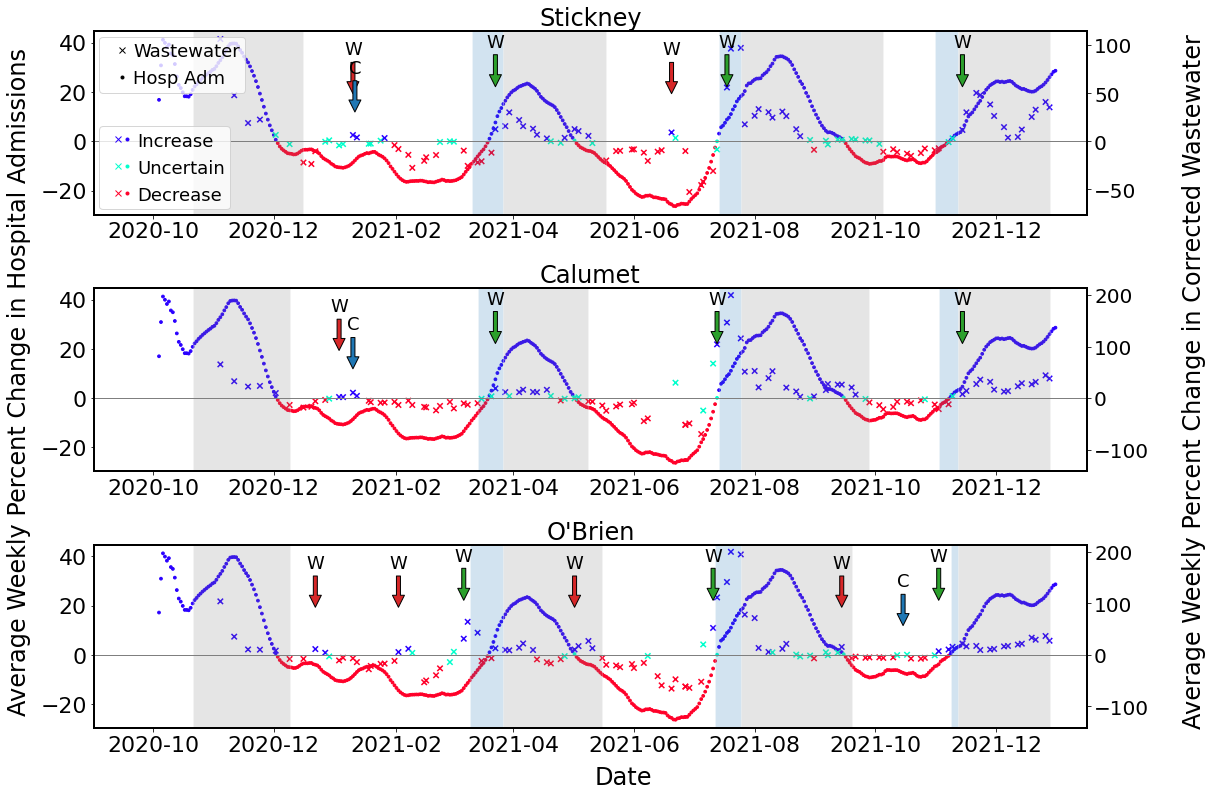

In [28]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']
wws = usewws    
num_weeks = num_weeks_ww
add_surge_arrows=False
n = 0
datatype = 'pmmov_bcov_flow_norm'
datalabel = 'Corrected Wastewater'
fig = plt.figure(figsize=(16,11))
gs = fig.add_gridspec(len(catches_shortlist), 1, wspace=None, hspace=None)
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
            if c==0: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('hospital admissions','Hosp Adm'))
                l1 = ax.legend(bbox_to_anchor=(0,1),loc='upper left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0,0),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch,'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date-datetime.timedelta(days=5)<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(30,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
fig.text(0.5, 0, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(-.01, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('hospital admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(1.01, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()


In [29]:
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2021-01-03'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-09-20'),'surge'] = '2021-11-12, pre:2021-09-14'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2021-01-10'
newsurgedf = FormatDatesNicely(surgedf)

source catchment  wastewater       cases  admissions    bedsused  \
0        Calumet  2021-01-03         NaN         NaN         NaN   
1        Calumet         NaN  2021-01-10         NaN         NaN   
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27   
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25   
4        Calumet  2021-11-14  2021-11-02  2021-11-08  2021-11-12   
5         OBrien  2020-12-22         NaN         NaN         NaN   
6         OBrien  2021-02-02         NaN         NaN         NaN   
7         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27   
8         OBrien  2021-05-02         NaN         NaN         NaN   
9         OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25   
10        OBrien  2021-09-14         NaN         NaN         NaN   
11        OBrien         NaN  2021-10-15         NaN         NaN   
12        OBrien  2021-11-02         NaN  2021-11-08  2021-11-12   
13      Stickney  2021-01-10         NaN         NaN         NaN   
14      Stickney         NaN  2021-01-11         NaN         NaN   
15      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27   
16      Stickney  2021-06-20         NaN         NaN         NaN   
17      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25   
18      Stickney  2021-11-14  2021-10-31  2021-11-08  2021-11-12   

source                       surge     w-a     c-a      b-a      w-c     w-b  
0       2021-03-27, pre:2021-01-03     NaT     NaT      NaT      NaT     NaT  
1       2021-03-27, pre:2021-01-10     NaT     NaT      NaT      NaT     NaT  
2                 2021-03-27-surge -3 days  6 days  -7 days  -9 days  4 days  
3                 2021-07-25-surge  1 days  0 days -11 days   1 days 12 days  
4                 2021-11-12-surge -6 days  6 days  -4 days -12 days -2 days  
5       2021-03-27, pre:2020-12-22     NaT     NaT      NaT      NaT     NaT  
6       2021-03-27, pre:2021-02-02     NaT     NaT      NaT      NaT     NaT  
7                 2021-03-27-surge 13 days 10 days  -7 days   3 days 20 days  
8       2021-07-25, pre:2021-05-02     NaT     NaT      NaT      NaT     NaT  
9                 2021-07-25-surge  3 days  2 days -11 days   1 days 14 days  
10      2021-11-12, pre:2021-09-14     NaT     NaT      NaT      NaT     NaT  
11      2021-11-12, pre:2021-10-15     NaT     NaT      NaT      NaT     NaT  
12                2021-11-12-surge  6 days     NaT  -4 days      NaT 10 days  
13      2021-03-27, pre:2021-01-10     NaT     NaT      NaT      NaT     NaT  
14      2021-03-27, pre:2021-01-11     NaT     NaT      NaT      NaT     NaT  
15                2021-03-27-surge -3 days  9 days  -7 days -12 days  4 days  
16      2021-07-25, pre:2021-06-20     NaT     NaT      NaT      NaT     NaT  
17                2021-07-25-surge -4 days  0 days -11 days  -4 days  7 days  
18                2021-11-12-surge -6 days  8 days  -4 days -14 days -2 days

Wastewater leads admissions in 4 surges by up to 13 days, and lags admissions in 5 surges by up to 6 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 3 days, and lags cases in 5 surges by up to 14 days.
Wastewater leads beds-in-use in all surges by -2 to 20 days.


In [30]:
surgetraining = surgedf.copy()

## Representative Admissions with BCoV example

In [31]:
lag = 2
useprev_single = 'hospital admissions'
usewws = ['orig-raw_data','only_bcov_norm']
wbe = pd.read_csv(wbefile, parse_dates=['date'])
wbe.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
wbe = CalculateModelFitsFromParams(wbe,paramdf,ww_lod,wwtp,lag,useprev_single)

In [32]:
aic2,param2,models = reformat_aic_params(aicdf,paramdf,trymodels)

In [33]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewws,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewws,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

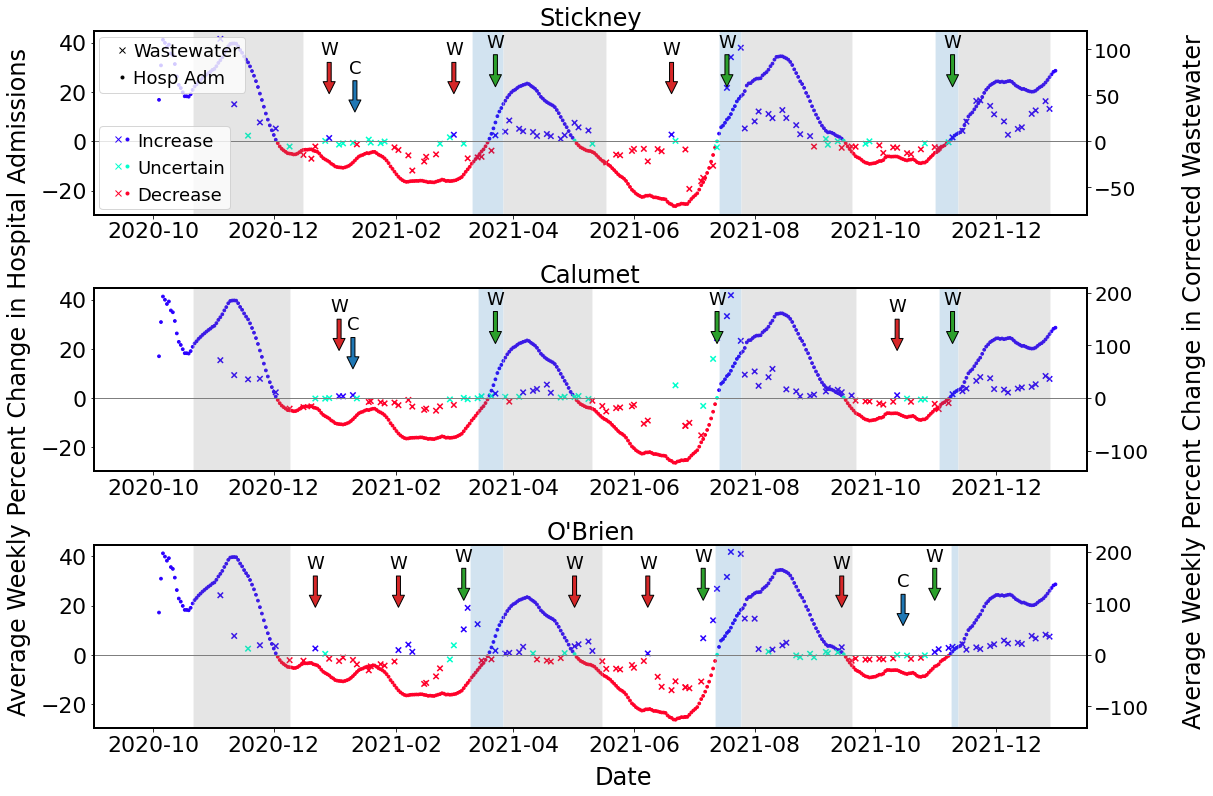

In [34]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']
wws = usewws    
num_weeks = num_weeks_ww
add_surge_arrows=False
n = 0
datatype = 'only_bcov_norm'
datalabel = 'Corrected Wastewater'
fig = plt.figure(figsize=(16,11))
gs = fig.add_gridspec(len(catches_shortlist), 1, wspace=None, hspace=None)
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
            if c==0: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('hospital admissions','Hosp Adm'))
                l1 = ax.legend(bbox_to_anchor=(0,1),loc='upper left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0,0),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch,'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(30,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
fig.text(0.5, 0, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(-.01, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('hospital admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(1.01, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()


In [35]:
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2021-01-03'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-09-20'),'surge'] = '2021-11-12, pre:2021-09-14'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2020-12-29'
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])


source catchment  wastewater       cases  admissions    bedsused  \
0        Calumet  2021-01-03         NaN         NaN         NaN   
1        Calumet         NaN  2021-01-10         NaN         NaN   
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27   
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25   
4        Calumet  2021-10-12         NaN         NaN         NaN   
5        Calumet  2021-11-09  2021-11-02  2021-11-08  2021-11-12   
6         OBrien  2020-12-22         NaN         NaN         NaN   
7         OBrien  2021-02-02         NaN         NaN         NaN   
8         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27   
9         OBrien  2021-05-02         NaN         NaN         NaN   
10        OBrien  2021-06-08         NaN         NaN         NaN   
11        OBrien  2021-07-06  2021-07-12  2021-07-14  2021-07-25   
12        OBrien  2021-09-14         NaN         NaN         NaN   
13        OBrien         NaN  2021-10-15         NaN         NaN   
14        OBrien  2021-10-31         NaN  2021-11-08  2021-11-12   
15      Stickney  2020-12-29         NaN         NaN         NaN   
16      Stickney         NaN  2021-01-11         NaN         NaN   
17      Stickney  2021-03-02         NaN         NaN         NaN   
18      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27   
19      Stickney  2021-06-20         NaN         NaN         NaN   
20      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25   
21      Stickney  2021-11-09  2021-10-31  2021-11-08  2021-11-12   

source                       surge     w-a     c-a      b-a      w-c     w-b  
0       2021-03-27, pre:2021-01-03     NaT     NaT      NaT      NaT     NaT  
1       2021-03-27, pre:2021-01-10     NaT     NaT      NaT      NaT     NaT  
2                 2021-03-27-surge -3 days  6 days  -7 days  -9 days  4 days  
3                 2021-07-25-surge  1 days  0 days -11 days   1 days 12 days  
4       2021-11-12, pre:2021-10-12     NaT     NaT      NaT      NaT     NaT  
5                 2021-11-12-surge -1 days  6 days  -4 days  -7 days  3 days  
6       2021-03-27, pre:2020-12-22     NaT     NaT      NaT      NaT     NaT  
7       2021-03-27, pre:2021-02-02     NaT     NaT      NaT      NaT     NaT  
8                 2021-03-27-surge 13 days 10 days  -7 days   3 days 20 days  
9       2021-07-25, pre:2021-05-02     NaT     NaT      NaT      NaT     NaT  
10      2021-07-25, pre:2021-06-08     NaT     NaT      NaT      NaT     NaT  
11                2021-07-25-surge  8 days  2 days -11 days   6 days 19 days  
12      2021-11-12, pre:2021-09-14     NaT     NaT      NaT      NaT     NaT  
13      2021-11-12, pre:2021-10-15     NaT     NaT      NaT      NaT     NaT  
14                2021-11-12-surge  8 days     NaT  -4 days      NaT 12 days  
15      2021-03-27, pre:2020-12-29     NaT     NaT      NaT      NaT     NaT  
16      2021-03-27, pre:2021-01-11     NaT     NaT      NaT      NaT     NaT  
17      2021-03-27, pre:2021-03-02     NaT     NaT      NaT      NaT     NaT  
18                2021-03-27-surge -3 days  9 days  -7 days -12 days  4 days  
19      2021-07-25, pre:2021-06-20     NaT     NaT      NaT      NaT     NaT  
20                2021-07-25-surge -4 days  0 days -11 days  -4 days  7 days  
21                2021-11-12-surge -1 days  8 days  -4 days  -9 days  3 days

Wastewater leads admissions in 4 surges by up to 13 days, and lags admissions in 5 surges by up to 4 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 6 days, and lags cases in 5 surges by up to 12 days.
Wastewater leads beds-in-use in all surges by 3 to 20 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet  2021-01-03         NaN         NaN         NaN
1        Calumet         NaN  2021-01-10         NaN         NaN
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
4        Calumet  2021-10-12         NaN         NaN         NaN
5        Calumet  2021-11-09  2021-11-02  2021-11-08  2021-11-12
6         OBrien  2020-12-22         NaN         NaN         NaN
7         OBrien  2021-02-02         NaN         NaN         NaN
8         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27
9         OBrien  2021-05-02         NaN         NaN         NaN
10        OBrien  2021-06-08         NaN         NaN         NaN
11        OBrien  2021-07-06  2021-07-12  2021-07-14  2021-07-25
12        OBrien  2021-09-14         NaN         NaN         NaN
13        OBrien         NaN  2021-10-15         NaN         NaN
14        OBrien  2021-10-31         NaN  2021-11-08  2021-11-12
15      Stickney  2020-12-29         NaN         NaN         NaN
16      Stickney         NaN  2021-01-11         NaN         NaN
17      Stickney  2021-03-02         NaN         NaN         NaN
18      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27
19      Stickney  2021-06-20         NaN         NaN         NaN
20      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
21      Stickney  2021-11-09  2021-10-31  2021-11-08  2021-11-12

In [36]:
surgebcov = surgedf.copy()

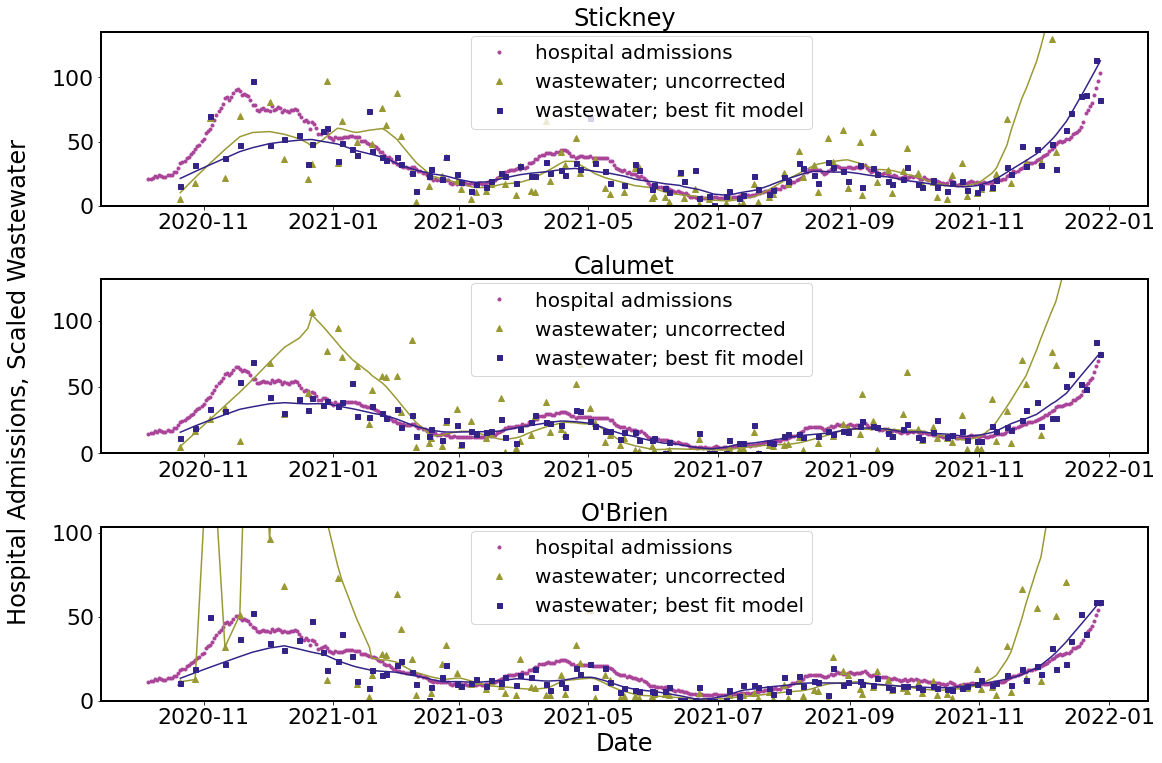

In [37]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels & titles
fs3 = 20 # legend
fig = plt.figure(figsize=(16,11))
mycolors = ['#AA4499','#999933','#332288','#88CCEE']
for j,catch in enumerate(catches_shortlist):
    plt.subplot(len(catches_shortlist),1,j+1)
    ax = plt.gca()
    startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
    enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
    maskp = (prevdf.catchment==catch) & (prevdf.date>=startdate) & (prevdf.date<=enddate)
    maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate)
    p = ax.plot(prevdf[maskp].date,prevdf[maskp][useprev_single],'.',color=mycolors[0],label=useprev_single.replace('sensitive','hospital'))
    ws = []
    for n,(ww,label) in enumerate(zip(usewws,['uncorrected','best fit model'])):
        ws = ax.plot(wbe[maskw].date,wbe[maskw][ww],marks[np.mod(n+1,3)],
                markersize=msize[np.mod(n+1,3)],color=mycolors[n+1],label='wastewater; '+label)
        smooth = sm.nonparametric.lowess(endog=wbe[maskw][ww], exog=mdates.date2num(wbe[maskw].date), frac= 0.1)
        ax.plot(smooth[:,0],smooth[:,1],'-',color=mycolors[n+1])
        p+=ws
        ax.set_ylim([0,ax.get_ylim()[1]/2])
        ax.xaxis.set_tick_params(labelsize=fs1)
        ax.yaxis.set_tick_params(labelsize=fs1)
        labs = [l.get_label() for l in p]
        ax.legend(p,labs,bbox_to_anchor=(.35,1),loc='upper left',borderaxespad=.2,fontsize=fs3)
        ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
ax.set_xlabel('Date',fontsize=fs2)
fig.text(-.02, 0.5, 'Hospital Admissions, Scaled Wastewater', va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()

Using lag = 2


catchment  Raw SARS-CoV-2  Corrected Wastewater
0  Stickney               3                     2
1   Calumet               7                     5
2    OBrien               7                     7
3      Egan               6                     6
4   Hanover              10                    10
5     Kirie              -1                    -4
6    Lemont              12                     7

catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.7447                0.8109    0.0816
1   Calumet          0.6853                0.8080    0.1519
2    OBrien          0.7139                0.7777    0.0820
3      Egan          0.7609                0.7862    0.0322
4   Hanover          0.5446                0.5178   -0.0518
5     Kirie          0.8001                0.8106    0.0130
6    Lemont          0.4644                0.6785    0.3155

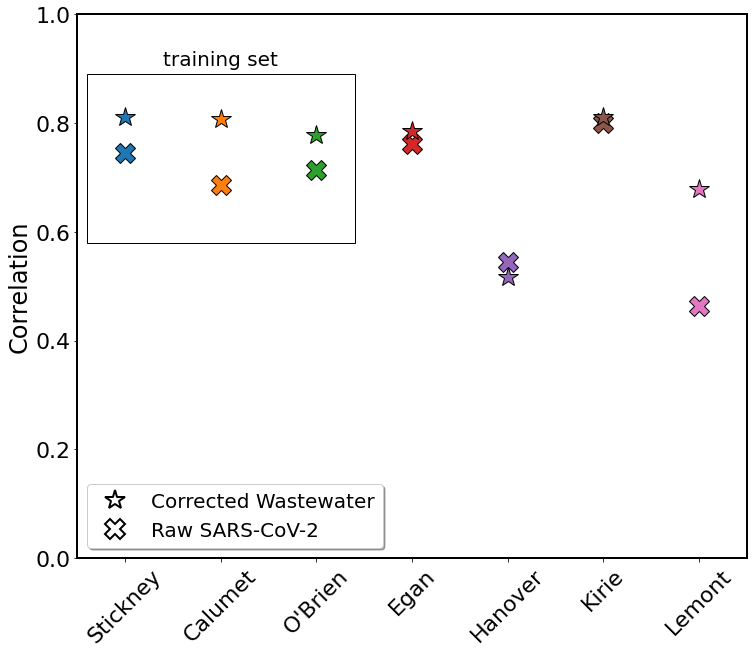

In [38]:
fs1 = 22 # tick labels 
fs2 = 24 # axis label
fs3 = 20 # legend & training annotation
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']

uselags = np.arange(-10,10,1)
show_corr_plot=False
box = [-.4,.58,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[useprev_single]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',useprev_single]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[useprev_single] = np.log10(pdf[useprev_single])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[useprev_single])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[useprev_single],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[useprev_single])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(12,10))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
if box!=None:
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate('training set',xy=(1,1),xycoords='figure fraction',
                   xytext=(1, .9), textcoords='data',
                   horizontalalignment='center',verticalalignment='bottom',fontsize=fs3)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45,fontsize=fs1)
ax.yaxis.set_tick_params(labelsize=fs1)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation',fontsize=fs2)
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=fs3)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

## Representative Admissions with PMMoV example

In [39]:
lag = 2
useprev_single = 'hospital admissions'
usewws = ['orig-raw_data','pmmov_norm']
wbe = pd.read_csv(wbefile, parse_dates=['date'])
wbe.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
wbe = CalculateModelFitsFromParams(wbe,paramdf,ww_lod,wwtp,lag,useprev_single)

In [40]:
aic2,param2,models = reformat_aic_params(aicdf,paramdf,trymodels)

In [41]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewws,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewws,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

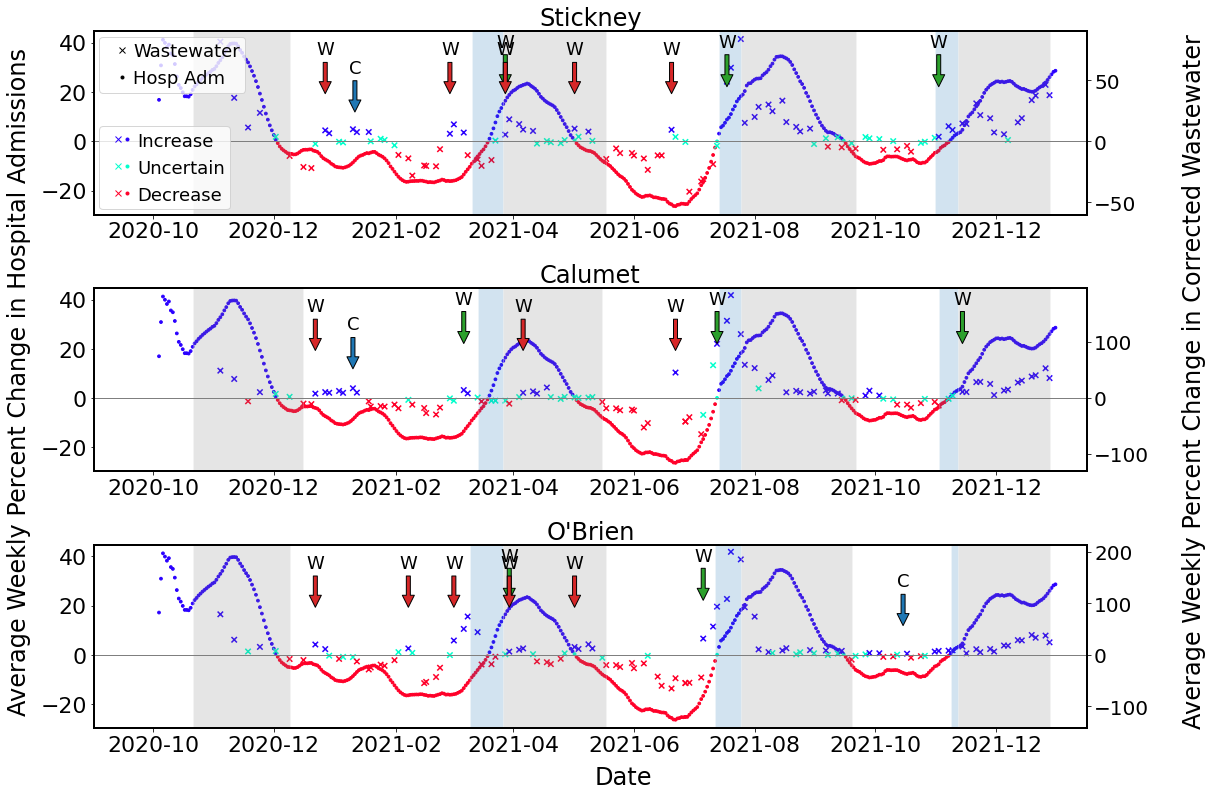

In [42]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']
wws = usewws    
num_weeks = num_weeks_ww
add_surge_arrows=False
n = 0
datatype = 'pmmov_norm'
datalabel = 'Corrected Wastewater'
fig = plt.figure(figsize=(16,11))
gs = fig.add_gridspec(len(catches_shortlist), 1, wspace=None, hspace=None)
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
            if c==0: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('hospital admissions','Hosp Adm'))
                l1 = ax.legend(bbox_to_anchor=(0,1),loc='upper left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0,0),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch,'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date-datetime.timedelta(days=5)<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(30,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
fig.text(0.5, 0, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(-.01, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('hospital admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(1.01, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()


In [43]:
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2020-12-22'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2020-12-27'
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])

source catchment  wastewater       cases  admissions    bedsused  \
0        Calumet  2020-12-22         NaN         NaN         NaN   
1        Calumet         NaN  2021-01-10         NaN         NaN   
2        Calumet  2021-03-07  2021-03-14  2021-03-20  2021-03-27   
3        Calumet  2021-04-06         NaN         NaN         NaN   
4        Calumet  2021-06-22         NaN         NaN         NaN   
5        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25   
6        Calumet  2021-11-14  2021-11-02  2021-11-08  2021-11-12   
7         OBrien  2020-12-22         NaN         NaN         NaN   
8         OBrien  2021-02-07         NaN         NaN         NaN   
9         OBrien  2021-03-02         NaN         NaN         NaN   
10        OBrien  2021-03-30  2021-03-10  2021-03-20  2021-03-27   
11        OBrien  2021-03-30         NaN         NaN         NaN   
12        OBrien  2021-05-02         NaN         NaN         NaN   
13        OBrien  2021-07-06  2021-07-12  2021-07-14  2021-07-25   
14        OBrien         NaN  2021-10-15         NaN         NaN   
15        OBrien         NaN         NaN  2021-11-08  2021-11-12   
16      Stickney  2020-12-27         NaN         NaN         NaN   
17      Stickney         NaN  2021-01-11         NaN         NaN   
18      Stickney  2021-02-28         NaN         NaN         NaN   
19      Stickney  2021-03-28  2021-03-11  2021-03-20  2021-03-27   
20      Stickney  2021-03-28         NaN         NaN         NaN   
21      Stickney  2021-05-02         NaN         NaN         NaN   
22      Stickney  2021-06-20         NaN         NaN         NaN   
23      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25   
24      Stickney  2021-11-02  2021-10-31  2021-11-08  2021-11-12   

source                       surge      w-a     c-a      b-a      w-c     w-b  
0       2021-03-27, pre:2020-12-22      NaT     NaT      NaT      NaT     NaT  
1       2021-03-27, pre:2021-01-10      NaT     NaT      NaT      NaT     NaT  
2                 2021-03-27-surge  13 days  6 days  -7 days   7 days 20 days  
3       2021-07-25, pre:2021-04-06      NaT     NaT      NaT      NaT     NaT  
4       2021-07-25, pre:2021-06-22      NaT     NaT      NaT      NaT     NaT  
5                 2021-07-25-surge   1 days  0 days -11 days   1 days 12 days  
6                 2021-11-12-surge  -6 days  6 days  -4 days -12 days -2 days  
7       2021-03-27, pre:2020-12-22      NaT     NaT      NaT      NaT     NaT  
8       2021-03-27, pre:2021-02-07      NaT     NaT      NaT      NaT     NaT  
9       2021-03-27, pre:2021-03-02      NaT     NaT      NaT      NaT     NaT  
10                2021-03-27-surge -10 days 10 days  -7 days -20 days -3 days  
11      2021-07-25, pre:2021-03-30      NaT     NaT      NaT      NaT     NaT  
12      2021-07-25, pre:2021-05-02      NaT     NaT      NaT      NaT     NaT  
13                2021-07-25-surge   8 days  2 days -11 days   6 days 19 days  
14      2021-11-12, pre:2021-10-15      NaT     NaT      NaT      NaT     NaT  
15                2021-11-12-surge      NaT     NaT  -4 days      NaT     NaT  
16      2021-03-27, pre:2020-12-27      NaT     NaT      NaT      NaT     NaT  
17      2021-03-27, pre:2021-01-11      NaT     NaT      NaT      NaT     NaT  
18      2021-03-27, pre:2021-02-28      NaT     NaT      NaT      NaT     NaT  
19                2021-03-27-surge  -8 days  9 days  -7 days -17 days -1 days  
20      2021-07-25, pre:2021-03-28      NaT     NaT      NaT      NaT     NaT  
21      2021-07-25, pre:2021-05-02      NaT     NaT      NaT      NaT     NaT  
22      2021-07-25, pre:2021-06-20      NaT     NaT      NaT      NaT     NaT  
23                2021-07-25-surge  -4 days  0 days -11 days  -4 days  7 days  
24                2021-11-12-surge   6 days  8 days  -4 days  -2 days 10 days

Wastewater leads admissions in 4 surges by up to 13 days, and lags admissions in 4 surges by up to 10 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 7 days, and lags cases in 5 surges by up to 20 days.
Wastewater leads beds-in-use in all surges by -3 to 20 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet  2020-12-22         NaN         NaN         NaN
1        Calumet         NaN  2021-01-10         NaN         NaN
2        Calumet  2021-03-07  2021-03-14  2021-03-20  2021-03-27
3        Calumet  2021-04-06         NaN         NaN         NaN
4        Calumet  2021-06-22         NaN         NaN         NaN
5        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
6        Calumet  2021-11-14  2021-11-02  2021-11-08  2021-11-12
7         OBrien  2020-12-22         NaN         NaN         NaN
8         OBrien  2021-02-07         NaN         NaN         NaN
9         OBrien  2021-03-02         NaN         NaN         NaN
10        OBrien  2021-03-30  2021-03-10  2021-03-20  2021-03-27
11        OBrien  2021-03-30         NaN         NaN         NaN
12        OBrien  2021-05-02         NaN         NaN         NaN
13        OBrien  2021-07-06  2021-07-12  2021-07-14  2021-07-25
14        OBrien         NaN  2021-10-15         NaN         NaN
15        OBrien         NaN         NaN  2021-11-08  2021-11-12
16      Stickney  2020-12-27         NaN         NaN         NaN
17      Stickney         NaN  2021-01-11         NaN         NaN
18      Stickney  2021-02-28         NaN         NaN         NaN
19      Stickney  2021-03-28  2021-03-11  2021-03-20  2021-03-27
20      Stickney  2021-03-28         NaN         NaN         NaN
21      Stickney  2021-05-02         NaN         NaN         NaN
22      Stickney  2021-06-20         NaN         NaN         NaN
23      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
24      Stickney  2021-11-02  2021-10-31  2021-11-08  2021-11-12

In [44]:
surgepmmov = surgedf.copy()

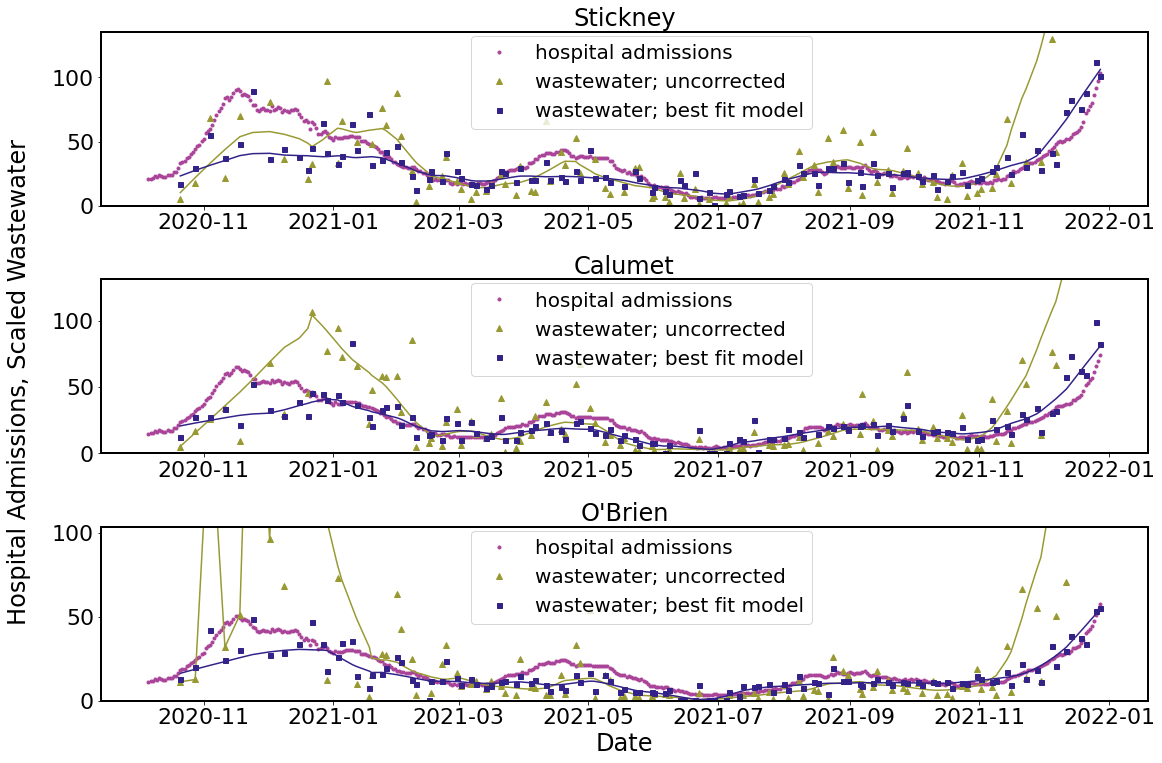

In [45]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels & titles
fs3 = 20 # legend
fig = plt.figure(figsize=(16,11))
mycolors = ['#AA4499','#999933','#332288','#88CCEE']
for j,catch in enumerate(catches_shortlist):
    plt.subplot(len(catches_shortlist),1,j+1)
    ax = plt.gca()
    startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
    enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
    maskp = (prevdf.catchment==catch) & (prevdf.date>=startdate) & (prevdf.date<=enddate)
    maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate)
    p = ax.plot(prevdf[maskp].date,prevdf[maskp][useprev_single],'.',color=mycolors[0],label=useprev_single.replace('sensitive','hospital'))
    ws = []
    for n,(ww,label) in enumerate(zip(usewws,['uncorrected','best fit model'])):
        ws = ax.plot(wbe[maskw].date,wbe[maskw][ww],marks[np.mod(n+1,3)],
                markersize=msize[np.mod(n+1,3)],color=mycolors[n+1],label='wastewater; '+label)
        smooth = sm.nonparametric.lowess(endog=wbe[maskw][ww], exog=mdates.date2num(wbe[maskw].date), frac= 0.1)
        ax.plot(smooth[:,0],smooth[:,1],'-',color=mycolors[n+1])
        p+=ws
        ax.set_ylim([0,ax.get_ylim()[1]/2])
        ax.xaxis.set_tick_params(labelsize=fs1)
        ax.yaxis.set_tick_params(labelsize=fs1)
        labs = [l.get_label() for l in p]
        ax.legend(p,labs,bbox_to_anchor=(.35,1),loc='upper left',borderaxespad=.2,fontsize=fs3)
        ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
ax.set_xlabel('Date',fontsize=fs2)
fig.text(-.02, 0.5, 'Hospital Admissions, Scaled Wastewater', va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()

Using lag = 2


catchment  Raw SARS-CoV-2  Corrected Wastewater
0  Stickney               3                     4
1   Calumet               7                     7
2    OBrien               7                     8
3      Egan               6                     6
4   Hanover              10                     8
5     Kirie              -1                    -5
6    Lemont              12                     8

catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.7447                0.7884    0.0554
1   Calumet          0.6853                0.7284    0.0592
2    OBrien          0.7139                0.7406    0.0361
3      Egan          0.7609                0.7813    0.0261
4   Hanover          0.5446                0.5126   -0.0624
5     Kirie          0.8001                0.8386    0.0459
6    Lemont          0.4644                0.7039    0.3402

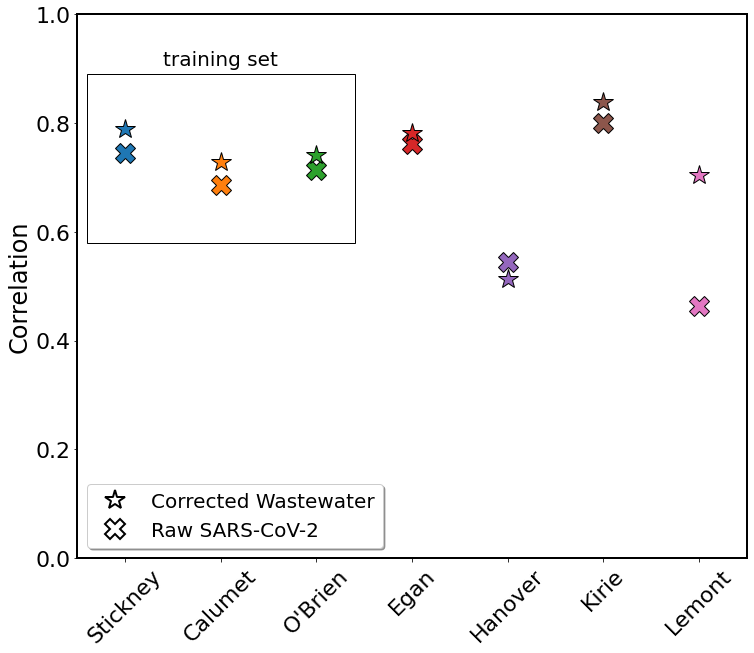

In [46]:
fs1 = 22 # tick labels 
fs2 = 24 # axis label
fs3 = 20 # legend & training annotation
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']

uselags = np.arange(-10,10,1)
show_corr_plot=False
box = [-.4,.58,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[useprev_single]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',useprev_single]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[useprev_single] = np.log10(pdf[useprev_single])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[useprev_single])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[useprev_single],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[useprev_single])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(12,10))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
if box!=None:
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate('training set',xy=(1,1),xycoords='figure fraction',
                   xytext=(1, .9), textcoords='data',
                   horizontalalignment='center',verticalalignment='bottom',fontsize=fs3)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45,fontsize=fs1)
ax.yaxis.set_tick_params(labelsize=fs1)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation',fontsize=fs2)
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=fs3)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

## Representative with beds all terms example?

In [47]:
lag = -1
useprev_single = 'Cook County beds in use'
usewws = ['orig-raw_data','pmmov_bcov_flow_norm']
wbe = pd.read_csv(wbefile, parse_dates=['date'])
wbe.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
wbe = CalculateModelFitsFromParams(wbe,paramdf,ww_lod,wwtp,lag,useprev_single)

In [48]:
aic2,param2,models = reformat_aic_params(aicdf,paramdf,trymodels)

In [49]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewws,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewws,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

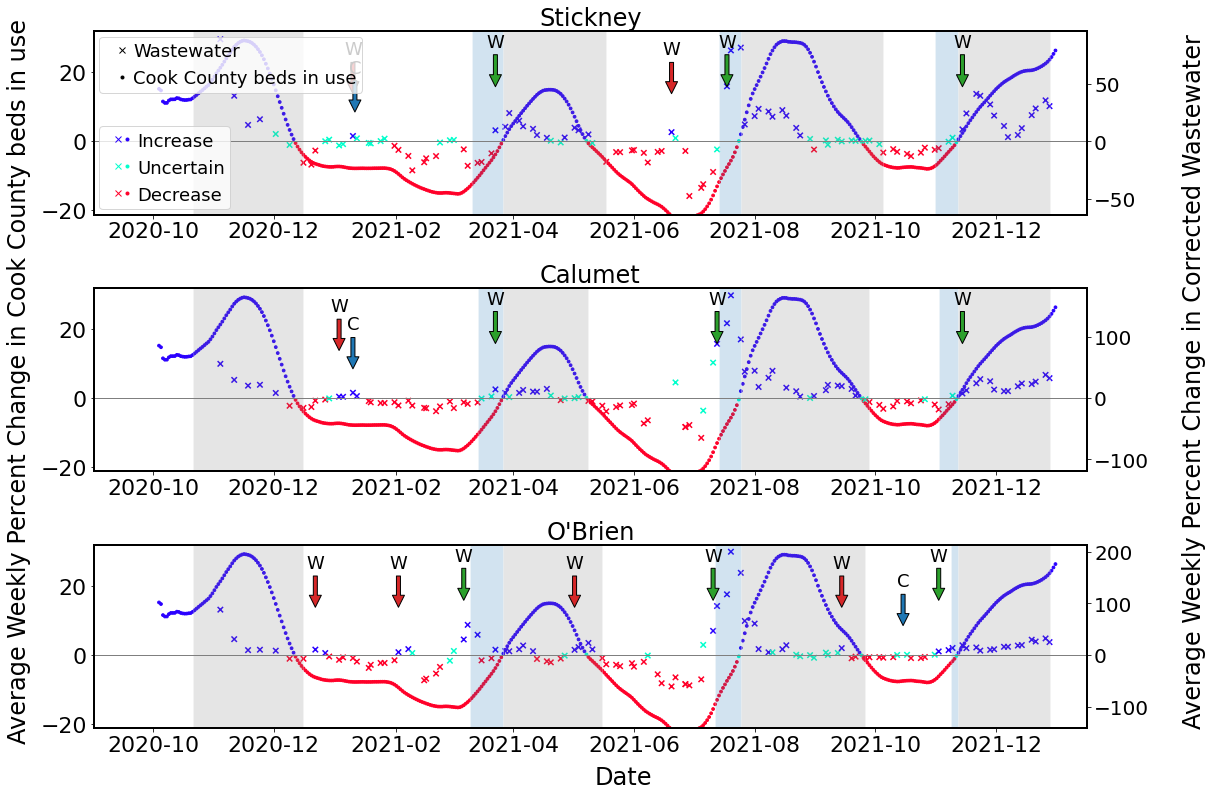

In [50]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']
wws = usewws    
num_weeks = num_weeks_ww
add_surge_arrows=False
n = 0
datatype = 'pmmov_bcov_flow_norm'
datalabel = 'Corrected Wastewater'
fig = plt.figure(figsize=(16,11))
gs = fig.add_gridspec(len(catches_shortlist), 1, wspace=None, hspace=None)
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
            if c==0: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('hospital admissions','Hosp Adm'))
                l1 = ax.legend(bbox_to_anchor=(0,1),loc='upper left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0,0),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch,'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date-datetime.timedelta(days=5)<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch,'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch,'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(30,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
fig.text(0.5, 0, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(-.01, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('hospital admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(1.01, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()


In [51]:
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2021-01-03'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-09-20'),'surge'] = '2021-11-12, pre:2021-09-14'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2021-01-10'
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])


source catchment  wastewater       cases  admissions    bedsused  \
0        Calumet  2021-01-03         NaN         NaN         NaN   
1        Calumet         NaN  2021-01-10         NaN         NaN   
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27   
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25   
4        Calumet  2021-11-14  2021-11-02  2021-11-08  2021-11-12   
5         OBrien  2020-12-22         NaN         NaN         NaN   
6         OBrien  2021-02-02         NaN         NaN         NaN   
7         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27   
8         OBrien  2021-05-02         NaN         NaN         NaN   
9         OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25   
10        OBrien  2021-09-14         NaN         NaN         NaN   
11        OBrien         NaN  2021-10-15         NaN         NaN   
12        OBrien  2021-11-02         NaN  2021-11-08  2021-11-12   
13      Stickney  2021-01-10         NaN         NaN         NaN   
14      Stickney         NaN  2021-01-11         NaN         NaN   
15      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27   
16      Stickney  2021-06-20         NaN         NaN         NaN   
17      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25   
18      Stickney  2021-11-14  2021-10-31  2021-11-08  2021-11-12   

source                       surge     w-a     c-a      b-a      w-c     w-b  
0       2021-03-27, pre:2021-01-03     NaT     NaT      NaT      NaT     NaT  
1       2021-03-27, pre:2021-01-10     NaT     NaT      NaT      NaT     NaT  
2                 2021-03-27-surge -3 days  6 days  -7 days  -9 days  4 days  
3                 2021-07-25-surge  1 days  0 days -11 days   1 days 12 days  
4                 2021-11-12-surge -6 days  6 days  -4 days -12 days -2 days  
5       2021-03-27, pre:2020-12-22     NaT     NaT      NaT      NaT     NaT  
6       2021-03-27, pre:2021-02-02     NaT     NaT      NaT      NaT     NaT  
7                 2021-03-27-surge 13 days 10 days  -7 days   3 days 20 days  
8       2021-07-25, pre:2021-05-02     NaT     NaT      NaT      NaT     NaT  
9                 2021-07-25-surge  3 days  2 days -11 days   1 days 14 days  
10      2021-11-12, pre:2021-09-14     NaT     NaT      NaT      NaT     NaT  
11      2021-11-12, pre:2021-10-15     NaT     NaT      NaT      NaT     NaT  
12                2021-11-12-surge  6 days     NaT  -4 days      NaT 10 days  
13      2021-03-27, pre:2021-01-10     NaT     NaT      NaT      NaT     NaT  
14      2021-03-27, pre:2021-01-11     NaT     NaT      NaT      NaT     NaT  
15                2021-03-27-surge -3 days  9 days  -7 days -12 days  4 days  
16      2021-07-25, pre:2021-06-20     NaT     NaT      NaT      NaT     NaT  
17                2021-07-25-surge -4 days  0 days -11 days  -4 days  7 days  
18                2021-11-12-surge -6 days  8 days  -4 days -14 days -2 days

Wastewater leads admissions in 4 surges by up to 13 days, and lags admissions in 5 surges by up to 6 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 3 days, and lags cases in 5 surges by up to 14 days.
Wastewater leads beds-in-use in all surges by -2 to 20 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet  2021-01-03         NaN         NaN         NaN
1        Calumet         NaN  2021-01-10         NaN         NaN
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
4        Calumet  2021-11-14  2021-11-02  2021-11-08  2021-11-12
5         OBrien  2020-12-22         NaN         NaN         NaN
6         OBrien  2021-02-02         NaN         NaN         NaN
7         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27
8         OBrien  2021-05-02         NaN         NaN         NaN
9         OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25
10        OBrien  2021-09-14         NaN         NaN         NaN
11        OBrien         NaN  2021-10-15         NaN         NaN
12        OBrien  2021-11-02         NaN  2021-11-08  2021-11-12
13      Stickney  2021-01-10         NaN         NaN         NaN
14      Stickney         NaN  2021-01-11         NaN         NaN
15      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27
16      Stickney  2021-06-20         NaN         NaN         NaN
17      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
18      Stickney  2021-11-14  2021-10-31  2021-11-08  2021-11-12

In [52]:
surgebeds = surgedf.copy()

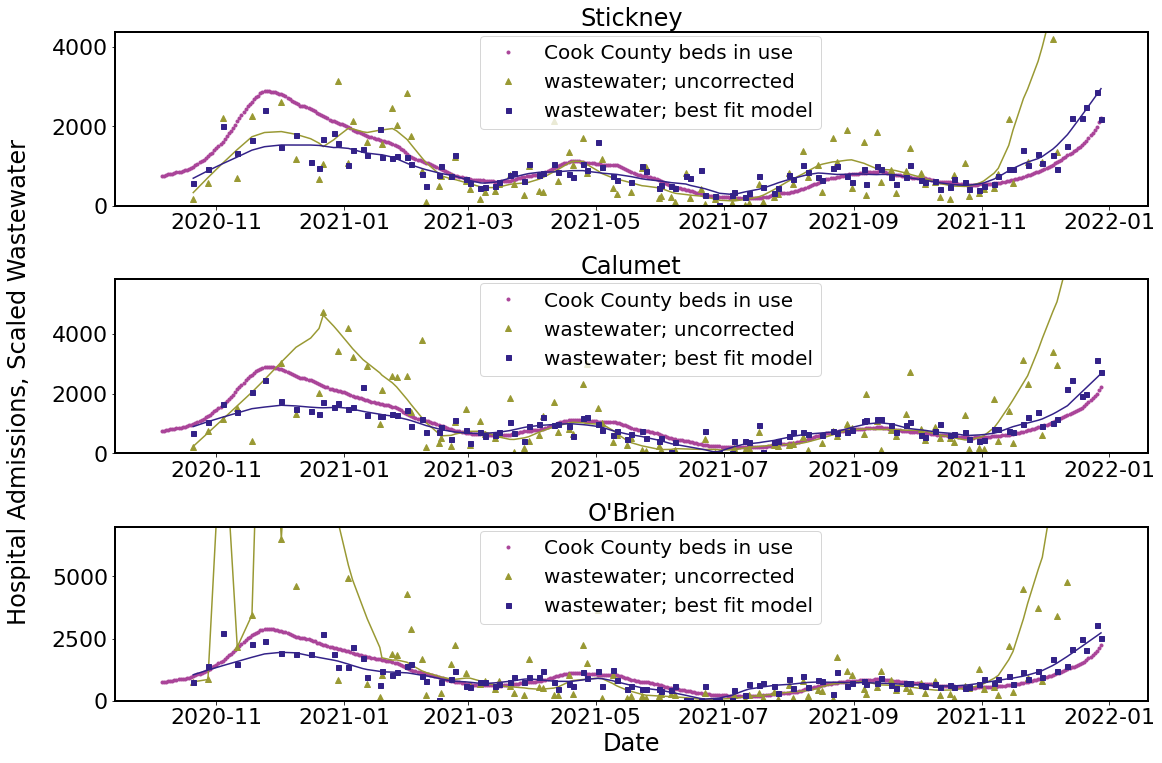

In [53]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels & titles
fs3 = 20 # legend
fig = plt.figure(figsize=(16,11))
mycolors = ['#AA4499','#999933','#332288','#88CCEE']
for j,catch in enumerate(catches_shortlist):
    plt.subplot(len(catches_shortlist),1,j+1)
    ax = plt.gca()
    startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
    enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
    maskp = (prevdf.catchment==catch) & (prevdf.date>=startdate) & (prevdf.date<=enddate)
    maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate)
    p = ax.plot(prevdf[maskp].date,prevdf[maskp][useprev_single],'.',color=mycolors[0],label=useprev_single.replace('sensitive','hospital'))
    ws = []
    for n,(ww,label) in enumerate(zip(usewws,['uncorrected','best fit model'])):
        ws = ax.plot(wbe[maskw].date,wbe[maskw][ww],marks[np.mod(n+1,3)],
                markersize=msize[np.mod(n+1,3)],color=mycolors[n+1],label='wastewater; '+label)
        smooth = sm.nonparametric.lowess(endog=wbe[maskw][ww], exog=mdates.date2num(wbe[maskw].date), frac= 0.1)
        ax.plot(smooth[:,0],smooth[:,1],'-',color=mycolors[n+1])
        p+=ws
        ax.set_ylim([0,ax.get_ylim()[1]/2])
        ax.xaxis.set_tick_params(labelsize=fs1)
        ax.yaxis.set_tick_params(labelsize=fs1)
        labs = [l.get_label() for l in p]
        ax.legend(p,labs,bbox_to_anchor=(.35,1),loc='upper left',borderaxespad=.2,fontsize=fs3)
        ax.set_title(catch.replace('OBrien',"O'Brien"),fontsize=fs2)
ax.set_xlabel('Date',fontsize=fs2)
fig.text(-.02, 0.5, 'Hospital Admissions, Scaled Wastewater', va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()

Using lag = -1


catchment  Raw SARS-CoV-2  Corrected Wastewater
0  Stickney              10                     8
1   Calumet              11                     9
2    OBrien              13                    13
3      Egan              13                    12
4   Hanover              11                    11
5     Kirie               2                     1
6    Lemont              19                     0

catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.7452                0.8318    0.1041
1   Calumet          0.6988                0.8324    0.1605
2    OBrien          0.7473                0.8132    0.0810
3      Egan          0.7542                0.7725    0.0237
4   Hanover          0.5659                0.5474   -0.0338
5     Kirie          0.8090                0.8154    0.0078
6    Lemont          0.4866                0.7599    0.3597

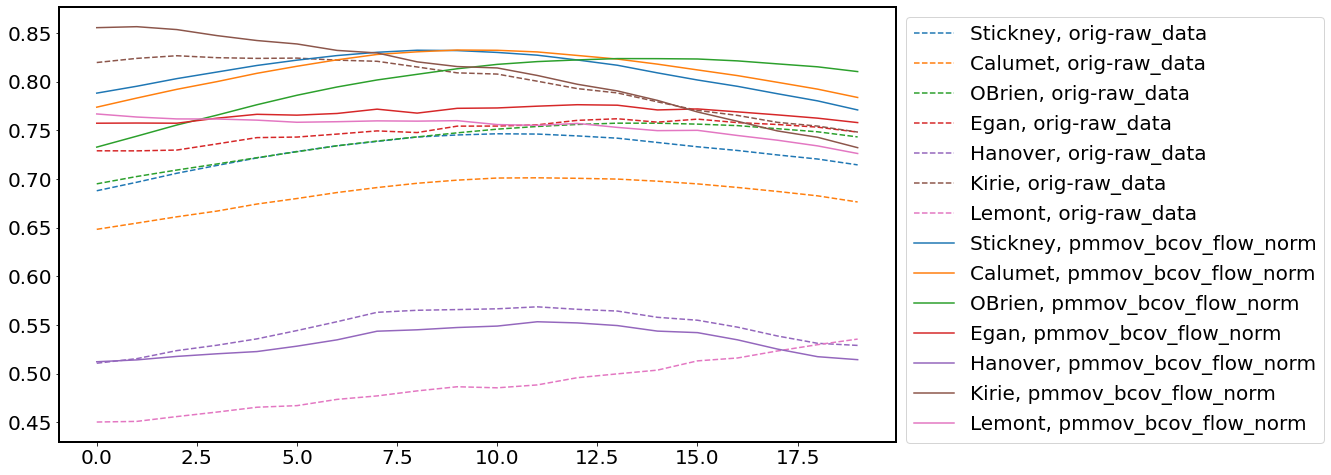

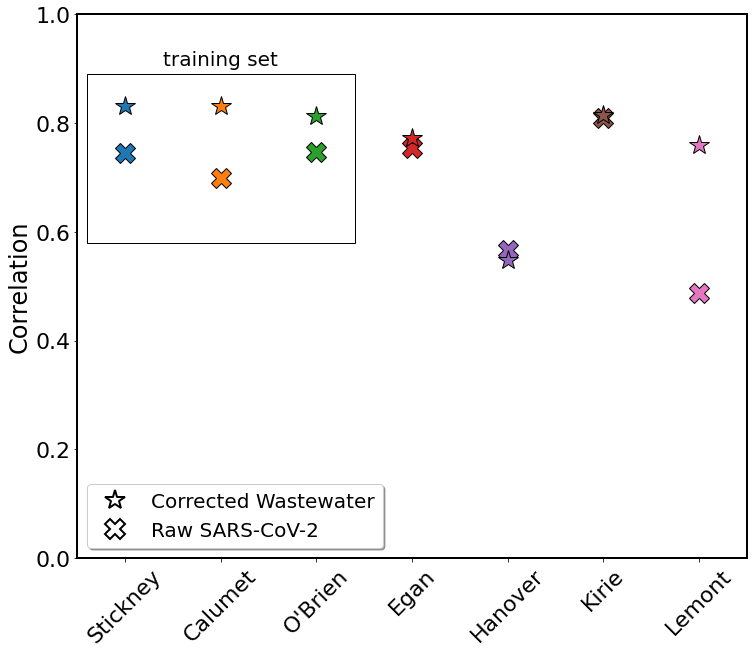

In [54]:
fs1 = 22 # tick labels 
fs2 = 24 # axis label
fs3 = 20 # legend & training annotation
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']
uselags = np.arange(-10,10,1)
show_corr_plot=True
useprev_single = 'Cook County beds in use'
box = [-.4,.58,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[useprev_single]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',useprev_single]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[useprev_single] = np.log10(pdf[useprev_single])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[useprev_single])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[useprev_single],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[useprev_single])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(12,10))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
if box!=None:
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate('training set',xy=(1,1),xycoords='figure fraction',
                   xytext=(1, .9), textcoords='data',
                   horizontalalignment='center',verticalalignment='bottom',fontsize=fs3)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45,fontsize=fs1)
ax.yaxis.set_tick_params(labelsize=fs1)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation',fontsize=fs2)
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=fs3)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

Using lag = -1


catchment  Raw SARS-CoV-2  Corrected Wastewater
0  Stickney               3                     2
1   Calumet               7                     5
2    OBrien               7                     7
3      Egan               6                     6
4   Hanover              10                     8
5     Kirie              -1                    -5
6    Lemont              12                     7

catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.7491                0.8261    0.0932
1   Calumet          0.6779                0.8094    0.1625
2    OBrien          0.7072                0.7789    0.0921
3      Egan          0.7487                0.7630    0.0187
4   Hanover          0.5382                0.5133   -0.0485
5     Kirie          0.8061                0.8110    0.0060
6    Lemont          0.4722                0.7578    0.3769

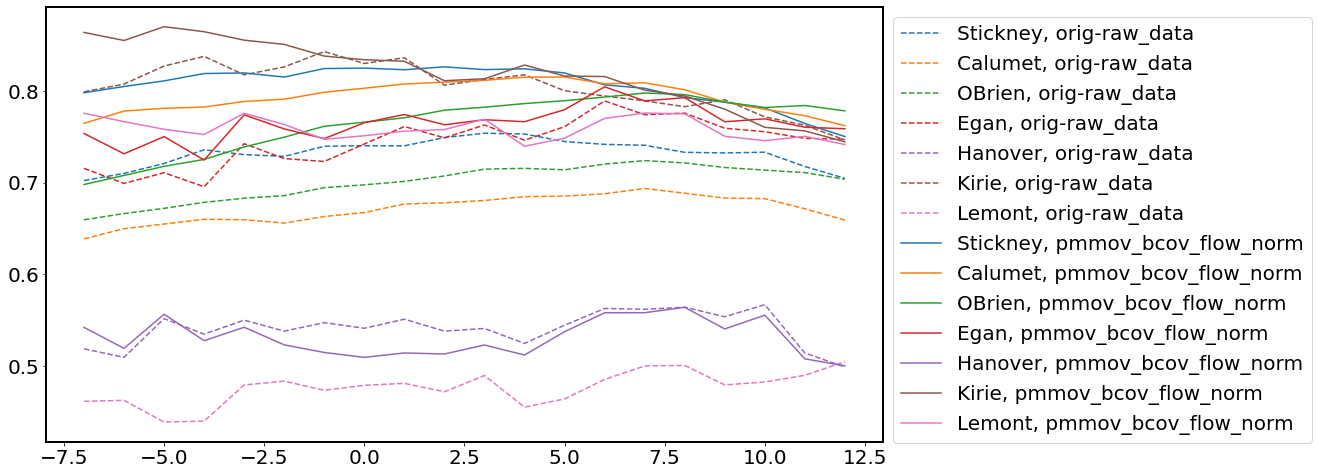

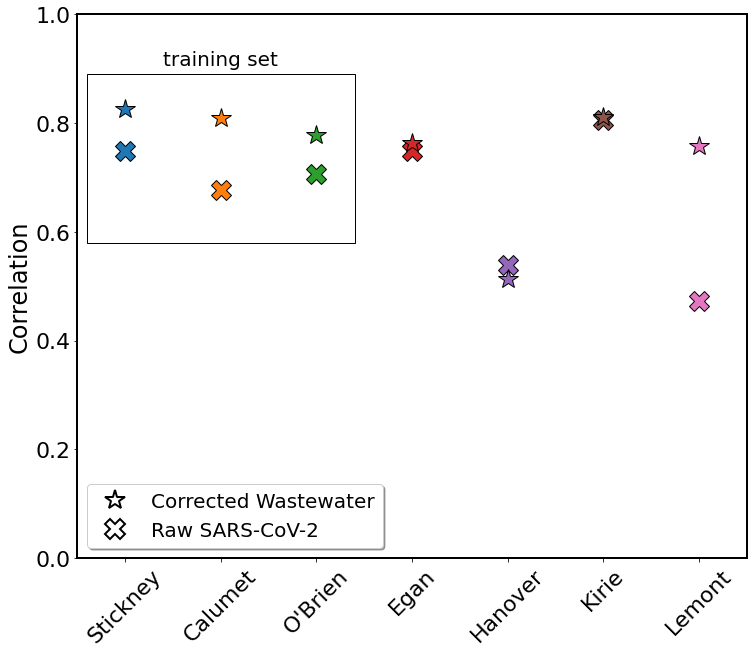

In [55]:
fs1 = 22 # tick labels 
fs2 = 24 # axis label
fs3 = 20 # legend & training annotation
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']
useprev_single = 'hospital admissions'
uselags = np.arange(-10,10,1)
show_corr_plot=True
box = [-.4,.58,2.8,0.31]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
        enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
        maskp = (prevdf.catchment==catch) & (prevdf[useprev_single]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        pdf = prevdf[maskp][['date',useprev_single]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[useprev_single] = np.log10(pdf[useprev_single])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[useprev_single])
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[useprev_single],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[useprev_single])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
print('Using lag =',lag)
display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(12,10))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
if box!=None:
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate('training set',xy=(1,1),xycoords='figure fraction',
                   xytext=(1, .9), textcoords='data',
                   horizontalalignment='center',verticalalignment='bottom',fontsize=fs3)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45,fontsize=fs1)
ax.yaxis.set_tick_params(labelsize=fs1)
ax.set_ylim([0,1])
ax.set_ylabel('Correlation',fontsize=fs2)
ledge = plt.legend(loc='lower left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=fs3)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

## Combined surgedf from different fits

In [56]:
surgebest.info()
surgetraining.info()
surgebcov.info()
surgepmmov.info()
surgebeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     47 non-null     object
 1   surge      47 non-null     object
 2   catchment  47 non-null     object
 3   date       47 non-null     object
dtypes: object(4)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     45 non-null     object
 1   surge      45 non-null     object
 2   catchment  45 non-null     object
 3   date       45 non-null     object
dtypes: object(4)
memory usage: 1.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     48 non-null     object
 1   surge      48 non-null  

In [57]:
surgeall = pd.concat([surgebest[surgebest.source=='wastewater'],surgetraining[surgetraining.source=='wastewater'],
                     surgebcov[surgebcov.source=='wastewater'],surgepmmov[surgepmmov.source=='wastewater'],
                     surgebeds[surgebeds.source=='wastewater']],axis=0, keys=['best','train','bcov','pmmov','beds']).reset_index(level=[0])
surgeall['source'] = surgeall['level_0']
surgeall.drop(columns='level_0',inplace=True)
surgeall.info()
surgeall.source.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 1 to 42
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     90 non-null     object
 1   surge      90 non-null     object
 2   catchment  90 non-null     object
 3   date       90 non-null     object
dtypes: object(4)
memory usage: 3.5+ KB


array(['best', 'train', 'bcov', 'pmmov', 'beds'], dtype=object)

In [58]:
surgeall.loc[(surgeall.catchment=='Calumet') & (surgeall.surge=='2021-03-27, pre:2020-12-22'),'surge'] = '2021-03-27, pre:2021-01-03'
surgeall.loc[(surgeall.catchment=='Calumet') & (surgeall.surge=='2021-03-27, pre:2020-12-29'),'surge'] = '2021-03-27, pre:2021-01-03'
surgeall.loc[(surgeall.catchment=='OBrien') & (surgeall.surge=='2021-03-27, pre:2021-02-07'),'surge'] = '2021-03-27, pre:2021-02-02'
surgeall.loc[(surgeall.catchment=='Stickney') & (surgeall.surge=='2021-03-27, pre:2020-12-27'),'surge'] = '2021-03-27, pre:2021-01-10'
surgeall.loc[(surgeall.catchment=='Stickney') & (surgeall.surge=='2021-03-27, pre:2020-12-29'),'surge'] = '2021-03-27, pre:2021-01-10'
surgeall.loc[(surgeall.catchment=='Stickney') & (surgeall.surge=='2021-03-27, pre:2021-02-28'),'surge'] = '2021-03-27, pre:2021-03-02'

newsurgedf = surgeall.pivot(index=['catchment','surge'],columns=['source'],values=['date'])['date'].reset_index()
newsurgedf.sort_values(by=['catchment','surge'],inplace=True)
newsurgedf = newsurgedf[['catchment','best','train','bcov','pmmov','beds','surge']]
display(newsurgedf[['catchment','best','train','bcov','pmmov','beds']])

source catchment        best       train        bcov       pmmov        beds
0        Calumet  2020-12-29  2021-01-03  2021-01-03  2020-12-22  2021-01-03
1        Calumet  2021-03-23  2021-03-23  2021-03-23  2021-03-07  2021-03-23
2        Calumet         NaN         NaN         NaN  2021-04-06         NaN
3        Calumet         NaN         NaN         NaN  2021-06-22         NaN
4        Calumet  2021-07-13  2021-07-13  2021-07-13  2021-07-13  2021-07-13
5        Calumet         NaN         NaN  2021-10-12         NaN         NaN
6        Calumet  2021-11-09  2021-11-14  2021-11-09  2021-11-14  2021-11-14
7         OBrien  2020-12-22  2020-12-22  2020-12-22  2020-12-22  2020-12-22
8         OBrien  2021-02-02  2021-02-02  2021-02-02  2021-02-07  2021-02-02
9         OBrien         NaN         NaN         NaN  2021-03-02         NaN
10        OBrien  2021-03-07  2021-03-07  2021-03-07  2021-03-30  2021-03-07
11        OBrien         NaN         NaN         NaN  2021-03-30         NaN
12        OBrien  2021-05-02  2021-05-02  2021-05-02  2021-05-02  2021-05-02
13        OBrien         NaN         NaN  2021-06-08         NaN         NaN
14        OBrien  2021-07-11  2021-07-11  2021-07-06  2021-07-06  2021-07-11
15        OBrien  2021-09-14  2021-09-14  2021-09-14         NaN  2021-09-14
16        OBrien  2021-10-31  2021-11-02  2021-10-31         NaN  2021-11-02
17      Stickney  2021-01-10  2021-01-10  2020-12-29  2020-12-27  2021-01-10
18      Stickney  2021-03-02         NaN  2021-03-02  2021-02-28         NaN
19      Stickney  2021-03-23  2021-03-23  2021-03-23  2021-03-28  2021-03-23
20      Stickney         NaN         NaN         NaN  2021-03-28         NaN
21      Stickney  2021-05-02         NaN         NaN  2021-05-02         NaN
22      Stickney  2021-06-20  2021-06-20  2021-06-20  2021-06-20  2021-06-20
23      Stickney  2021-07-18  2021-07-18  2021-07-18  2021-07-18  2021-07-18
24      Stickney  2021-11-07  2021-11-14  2021-11-09  2021-11-02  2021-11-14